In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import xgboost as xgb
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

Data Processing

In [ ]:
files = [
    "ad_viz_plotval_data.csv",
    "ad_viz_plotval_data-2.csv",
    "ad_viz_plotval_data-3.csv",
    "ad_viz_plotval_data-4.csv",
    "ad_viz_plotval_data-5.csv",
    "ad_viz_plotval_data-6.csv",
    "ad_viz_plotval_data-7.csv",
    "ad_viz_plotval_data-8.csv",
    "ad_viz_plotval_data-9.csv",
    "ad_viz_plotval_data-10.csv"
]

df_list = []

for f in files:
    df = pd.read_csv(f, sep=",", quotechar='"', skipinitialspace=True)

    df.columns = df.columns.str.strip()

    df.columns = df.columns.str.replace('^"|"$', '', regex=True)

    print(f"Columns in {f}: {df.columns.tolist()}")
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
print("Combined columns:", combined_df.columns.tolist())

selected_columns = [
    "Date",
    "Daily Mean PM2.5 Concentration",
    "Daily AQI Value",
    "County"
]

missing_cols = [col for col in selected_columns if col not in combined_df.columns]
if missing_cols:
    raise KeyError(f"Missing columns in the dataset: {missing_cols}")

combined_df = combined_df[selected_columns]

combined_df['Date'] = pd.to_datetime(combined_df['Date'], errors='coerce')
combined_df = combined_df.dropna(subset=['Date'])

combined_df = combined_df.sort_values('Date')

combined_df = combined_df.dropna(subset=["Daily Mean PM2.5 Concentration", "Daily AQI Value", "County"])

combined_df.to_csv("combined_aqi_data.csv", index=False)
print("Combined dataset shape:", combined_df.shape)
print("Data saved to combined_aqi_data.csv")

Columns in ad_viz_plotval_data.csv: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'Method Description', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']
Columns in ad_viz_plotval_data-2.csv: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQS Parameter Code', 'AQS Parameter Description', 'Method Code', 'Method Description', 'CBSA Code', 'CBSA Name', 'State FIPS Code', 'State', 'County FIPS Code', 'County', 'Site Latitude', 'Site Longitude']
Columns in ad_viz_plotval_data-3.csv: ['Date', 'Source', 'Site ID', 'POC', 'Daily Mean PM2.5 Concentration', 'Units', 'Daily AQI Value', 'Local Site Name', 'Daily Obs Count', 'Percent Complete', 'AQ

In [ ]:
df = pd.read_csv("combined_aqi_data.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df = df.dropna(subset=["Daily AQI Value"])

print("Original AQI Summary:")
print(df["Daily AQI Value"].describe())

q1 = df["Daily AQI Value"].quantile(0.25)
q3 = df["Daily AQI Value"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_filtered = df[(df["Daily AQI Value"] >= lower_bound) & (df["Daily AQI Value"] <= upper_bound)]

print("\nFiltered AQI Summary (IQR method):")
print(df_filtered["Daily AQI Value"].describe())

df_filtered.to_csv("combined_aqi_data_iqr.csv", index=False)
print("\nFiltered data saved to combined_aqi_data_iqr.csv")

Original AQI Summary:
count    545843.000000
mean         42.124118
std          26.158369
min           0.000000
25%          24.000000
50%          41.000000
75%          55.000000
max        1493.000000
Name: Daily AQI Value, dtype: float64

Filtered AQI Summary (IQR method):
count    536242.000000
mean         40.249913
std          19.945794
min           0.000000
25%          24.000000
50%          40.000000
75%          55.000000
max         101.000000
Name: Daily AQI Value, dtype: float64

Filtered data saved to combined_aqi_data_iqr.csv


First five rows of the dataset:
         Date  Daily Mean PM2.5 Concentration  Daily AQI Value  \
0  2015-01-01                            24.7               80   
66 2015-01-01                            17.7               67   
65 2015-01-01                            27.2               85   
64 2015-01-01                             9.0               50   
63 2015-01-01                            14.2               61   

             County  
0            Fresno  
66          Ventura  
65      Los Angeles  
64  San Luis Obispo  
63          Ventura  

Summary Statistics for Daily AQI Value:
count    536242.000000
mean         40.249913
std          19.945794
min           0.000000
25%          24.000000
50%          40.000000
75%          55.000000
max         101.000000
Name: Daily AQI Value, dtype: float64

Summary Statistics for Daily Mean PM2.5 Concentration:
count    536242.000000
mean          8.559123
std           5.955621
min         -22.100000
25%           4.400000
50%  

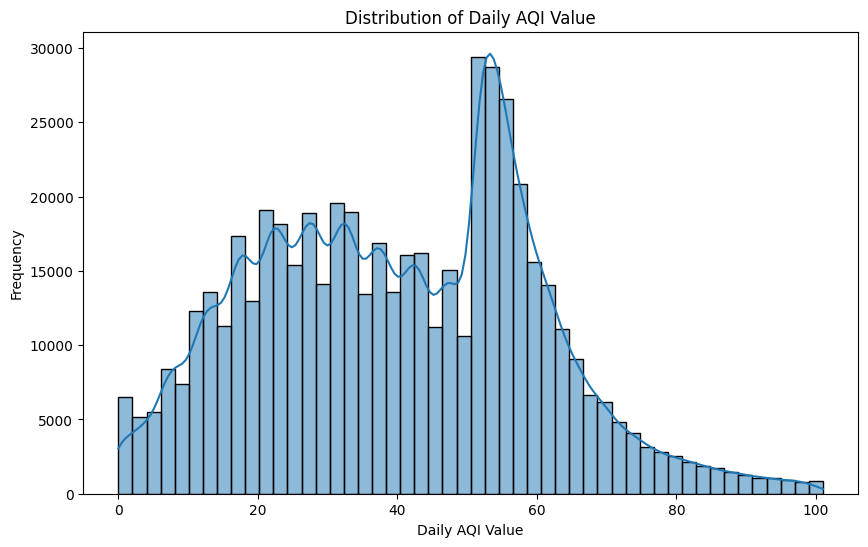

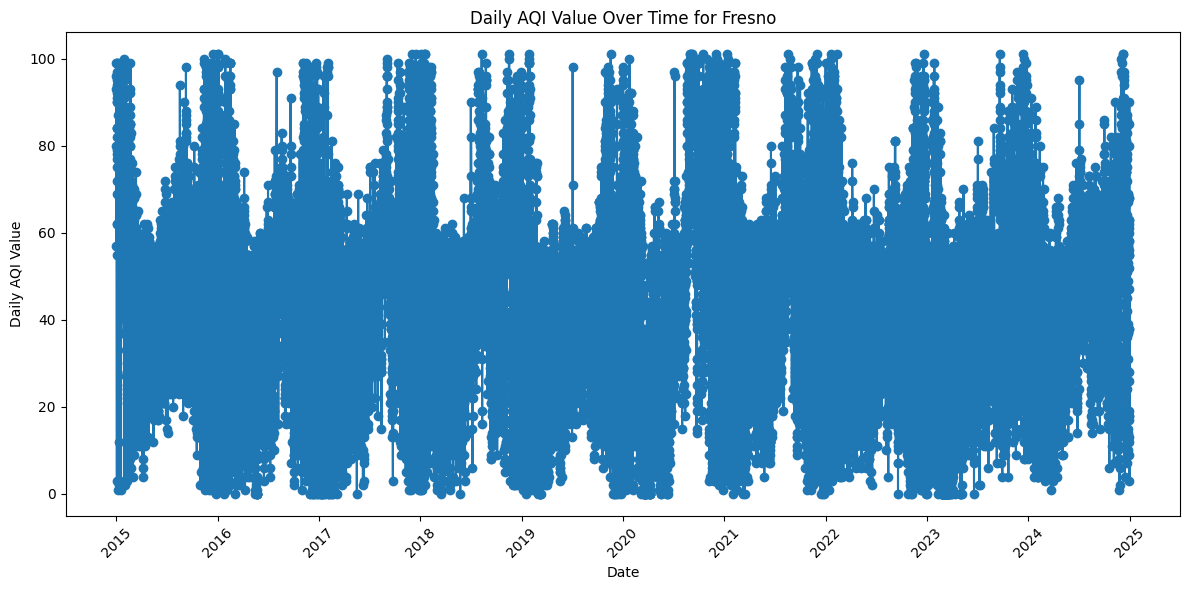

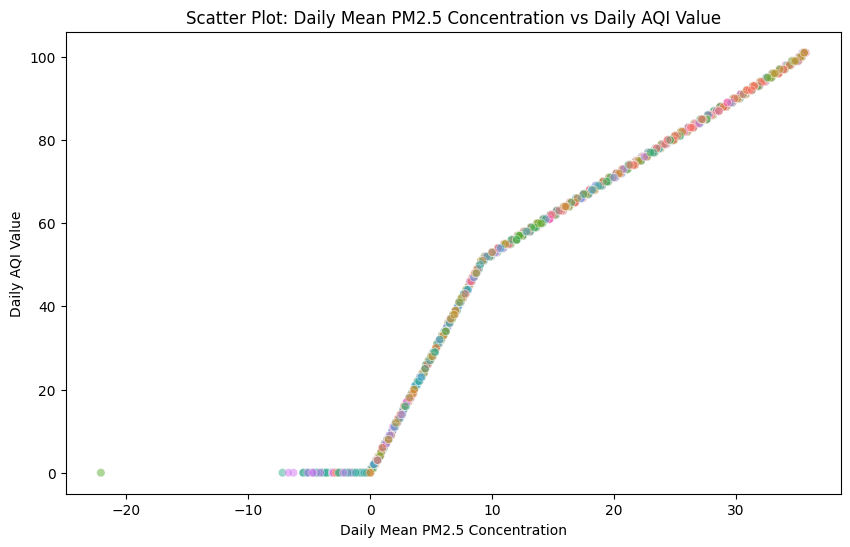

In [ ]:
df = pd.read_csv("combined_aqi_data_iqr.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

print("First five rows of the dataset:")
print(df.head())

print("\nSummary Statistics for Daily AQI Value:")
print(df["Daily AQI Value"].describe())

if "Daily Mean PM2.5 Concentration" in df.columns:
    print("\nSummary Statistics for Daily Mean PM2.5 Concentration:")
    print(df["Daily Mean PM2.5 Concentration"].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df["Daily AQI Value"], bins=50, kde=True)
plt.title("Distribution of Daily AQI Value")
plt.xlabel("Daily AQI Value")
plt.ylabel("Frequency")
plt.show()

sample_county = df["County"].unique()[0]
df_sample = df[df["County"] == sample_county]
plt.figure(figsize=(12, 6))
plt.plot(df_sample["Date"], df_sample["Daily AQI Value"], marker='o', linestyle='-')
plt.title(f"Daily AQI Value Over Time for {sample_county}")
plt.xlabel("Date")
plt.ylabel("Daily AQI Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

if "Daily Mean PM2.5 Concentration" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="Daily Mean PM2.5 Concentration", y="Daily AQI Value", hue="County", alpha=0.5, legend=False)
    plt.title("Scatter Plot: Daily Mean PM2.5 Concentration vs Daily AQI Value")
    plt.xlabel("Daily Mean PM2.5 Concentration")
    plt.ylabel("Daily AQI Value")
    plt.show()

Summary Statistics for PM2.5:
count    545843.000000
mean          9.540364
std          11.678753
min         -22.100000
25%           4.400000
50%           7.400000
75%          11.500000
max         824.100000
Name: Daily Mean PM2.5 Concentration, dtype: float64

Summary Statistics for AQI:
count    545843.000000
mean         42.124118
std          26.158369
min           0.000000
25%          24.000000
50%          41.000000
75%          55.000000
max        1493.000000
Name: Daily AQI Value, dtype: float64


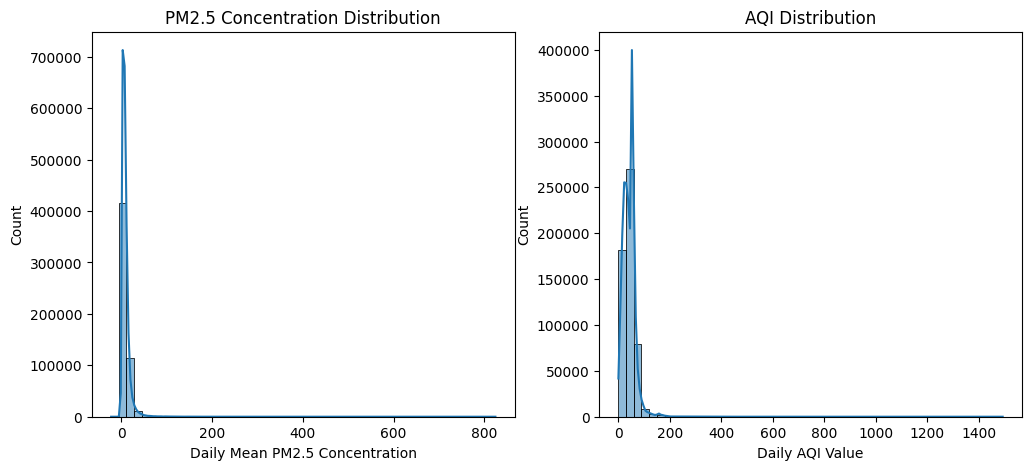

In [ ]:
df = pd.read_csv("combined_aqi_data.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

df['Daily Mean PM2.5 Concentration'] = pd.to_numeric(df['Daily Mean PM2.5 Concentration'], errors='coerce')
df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df = df.dropna(subset=["Daily Mean PM2.5 Concentration", "Daily AQI Value"])

print("Summary Statistics for PM2.5:")
print(df['Daily Mean PM2.5 Concentration'].describe())
print("\nSummary Statistics for AQI:")
print(df['Daily AQI Value'].describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Daily Mean PM2.5 Concentration'], bins=50, kde=True)
plt.title("PM2.5 Concentration Distribution")
plt.subplot(1, 2, 2)
sns.histplot(df['Daily AQI Value'], bins=50, kde=True)
plt.title("AQI Distribution")
plt.show()


Baselines

In [ ]:
warnings.filterwarnings("ignore")

df = pd.read_csv("combined_aqi_data_iqr.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df['Daily Mean PM2.5 Concentration'] = pd.to_numeric(df['Daily Mean PM2.5 Concentration'], errors='coerce')
df = df.dropna(subset=["Daily AQI Value", "Daily Mean PM2.5 Concentration"])

target_vars = ['Daily AQI Value', 'Daily Mean PM2.5 Concentration']

def persistence_forecast(series, train_size):
    test_series = series[train_size:]
    persistence = series[train_size-1:-1]
    rmse = np.sqrt(mean_squared_error(test_series, persistence))
    mae = mean_absolute_error(test_series, persistence)
    return rmse, mae

def arima_forecast(series, train_size, order=(1,1,0)):
    train_series = series[:train_size]
    test_series = series[train_size:]
    try:
        model = ARIMA(train_series, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_series))
        rmse = np.sqrt(mean_squared_error(test_series, forecast))
        mae = mean_absolute_error(test_series, forecast)
    except Exception as e:
        print("ARIMA error:", e)
        rmse, mae = np.nan, np.nan
    return rmse, mae

results = []

for county, group in df.groupby("County"):
    group = group.sort_values("Date")
    if len(group) < 50:
        continue
    for target_var in target_vars:
        series = group[target_var].values.astype(np.float32)
        train_size = int(len(series) * 0.8)
        if train_size < 2 or len(series) - train_size < 1:
            continue

        p_rmse, p_mae = persistence_forecast(series, train_size)

        a_rmse, a_mae = arima_forecast(series, train_size, order=(1,1,0))

        results.append({
            "County": county,
            "Variable": target_var,
            "Data Points": len(series),
            "Persistence RMSE": p_rmse,
            "Persistence MAE": p_mae,
            "ARIMA RMSE": a_rmse,
            "ARIMA MAE": a_mae
        })

results_df = pd.DataFrame(results)
print("Summary of Statistical Baselines by County:")
print(results_df)

Summary of Statistical Baselines by County:
        County                        Variable  Data Points  Persistence RMSE  \
0      Alameda                 Daily AQI Value        18383         13.411015   
1      Alameda  Daily Mean PM2.5 Concentration        18383          3.335954   
2        Butte                 Daily AQI Value        11990         16.796952   
3        Butte  Daily Mean PM2.5 Concentration        11990          4.796698   
4    Calaveras                 Daily AQI Value         3361         11.095225   
..         ...                             ...          ...               ...   
97      Tulare  Daily Mean PM2.5 Concentration         9961          6.910169   
98     Ventura                 Daily AQI Value        21319         13.039718   
99     Ventura  Daily Mean PM2.5 Concentration        21319          2.823482   
100       Yolo                 Daily AQI Value         5083         15.197908   
101       Yolo  Daily Mean PM2.5 Concentration         5083      

County-level Baseline Results:
             County  Data Points  Persistence RMSE  Persistence MAE  \
0           Alameda        18383         13.411015        10.182214   
1             Butte        11990         16.796952        12.221851   
2         Calaveras         3361         11.095225         8.280832   
3            Colusa         6413         22.279350        17.608730   
4      Contra Costa         7289         21.337721        16.845678   
5         Del Norte         3189         16.452839        12.877743   
6         El Dorado         2058         12.507376         8.798544   
7            Fresno        26618         18.080960        13.436890   
8             Glenn         3408         14.561428        10.524927   
9          Humboldt         3145         15.672980        11.718601   
10         Imperial        11338         17.964521        13.186949   
11             Inyo        17010         21.601054        14.154615   
12             Kern        20549         25.21

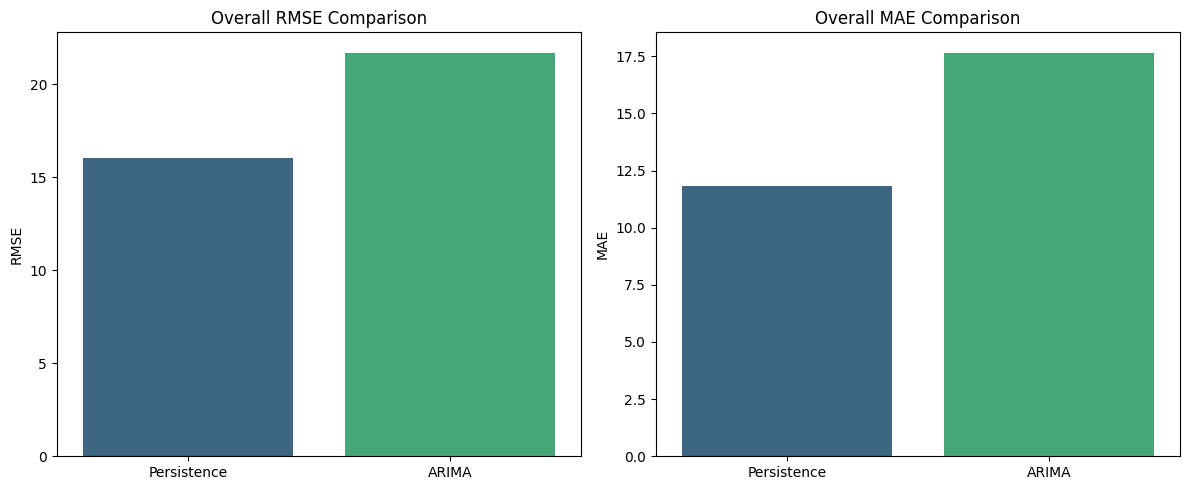

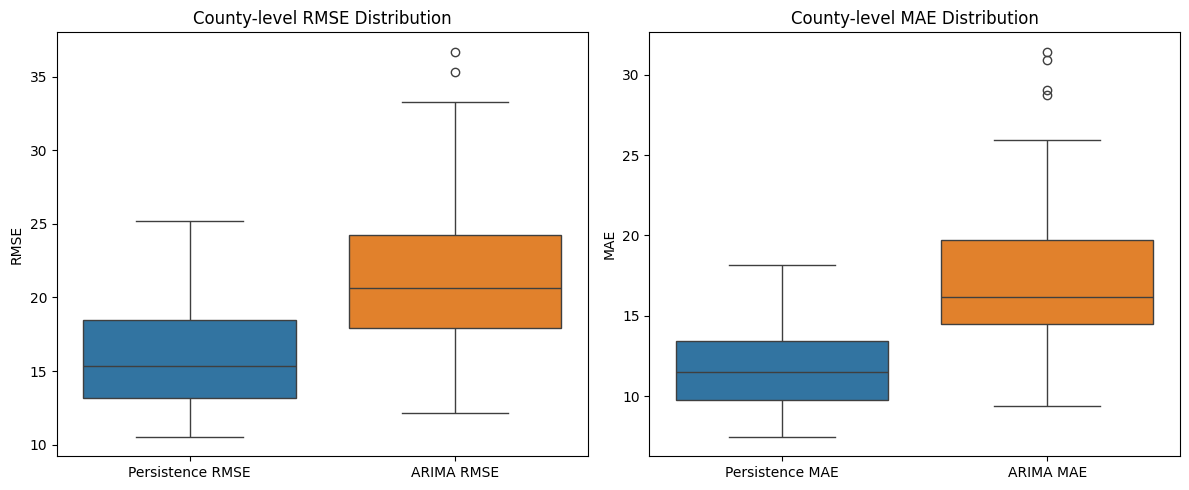

In [ ]:
warnings.filterwarnings("ignore")

df = pd.read_csv("combined_aqi_data_iqr.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')

df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df['Daily Mean PM2.5 Concentration'] = pd.to_numeric(df['Daily Mean PM2.5 Concentration'], errors='coerce')
df = df.dropna(subset=["Daily AQI Value", "Daily Mean PM2.5 Concentration"])

target_var = "Daily AQI Value"

results = []

for county, group in df.groupby("County"):
    group = group.sort_values("Date")
    ts = group[target_var].values.astype(np.float32)
    if len(ts) < 50:
        continue

    train_size = int(len(ts) * 0.8)
    if train_size < 2 or len(ts) - train_size < 1:
        continue

    test_series = ts[train_size:]
    persistence_forecast = ts[train_size-1:-1]
    p_rmse = np.sqrt(mean_squared_error(test_series, persistence_forecast))
    p_mae = mean_absolute_error(test_series, persistence_forecast)

    try:
        model_arima = ARIMA(ts[:train_size], order=(1,1,0))
        model_fit = model_arima.fit()
        forecast = model_fit.forecast(steps=len(ts) - train_size)
        a_rmse = np.sqrt(mean_squared_error(test_series, forecast))
        a_mae = mean_absolute_error(test_series, forecast)
    except Exception as e:
        print(f"ARIMA failed for county {county}:", e)
        a_rmse, a_mae = np.nan, np.nan

    results.append({
        "County": county,
        "Data Points": len(ts),
        "Persistence RMSE": p_rmse,
        "Persistence MAE": p_mae,
        "ARIMA RMSE": a_rmse,
        "ARIMA MAE": a_mae
    })

results_df = pd.DataFrame(results)
print("County-level Baseline Results:")
print(results_df)

overall_persistence_rmse = results_df["Persistence RMSE"].mean()
overall_arima_rmse = results_df["ARIMA RMSE"].mean()
overall_persistence_mae = results_df["Persistence MAE"].mean()
overall_arima_mae = results_df["ARIMA MAE"].mean()

print("\nOverall Aggregated Metrics:")
print(f"Persistence - RMSE: {overall_persistence_rmse:.2f}, MAE: {overall_persistence_mae:.2f}")
print(f"ARIMA       - RMSE: {overall_arima_rmse:.2f}, MAE: {overall_arima_mae:.2f}")

metrics = ['Persistence', 'ARIMA']
rmse_values = [overall_persistence_rmse, overall_arima_rmse]
mae_values = [overall_persistence_mae, overall_arima_mae]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x=metrics, y=rmse_values, palette="viridis")
plt.title("Overall RMSE Comparison")
plt.ylabel("RMSE")

plt.subplot(1,2,2)
sns.barplot(x=metrics, y=mae_values, palette="viridis")
plt.title("Overall MAE Comparison")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=results_df[['Persistence RMSE', 'ARIMA RMSE']])
plt.title("County-level RMSE Distribution")
plt.ylabel("RMSE")

plt.subplot(1,2,2)
sns.boxplot(data=results_df[['Persistence MAE', 'ARIMA MAE']])
plt.title("County-level MAE Distribution")
plt.ylabel("MAE")
plt.tight_layout()
plt.show()

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedBaseline(nn.Module):
    def __init__(self, county_vocab_size, county_emb_dim=1):
        super(CountyConditionedBaseline, self).__init__()
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, x, county_id):
        last_value = x[:, -1, 0]
        county_bias = self.county_embedding(county_id).squeeze(1)
        return last_value + self.global_bias + county_bias

def train_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    county_vocab_size = len(dataset.county_to_id)
    print(f"Total samples: {len(dataset)}, Number of counties: {county_vocab_size}")

    train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CountyConditionedBaseline(county_vocab_size=county_vocab_size, county_emb_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Starting training of the county-conditioned baseline model...")
    num_epochs = 20
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
    print("County-Conditioned Baseline Model Evaluation:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

if __name__ == "__main__":
    main()

Total samples: 534682, Number of counties: 52
Starting training of the county-conditioned baseline model...
Epoch 1/20, Loss: 315.9130
Epoch 2/20, Loss: 315.5462
Epoch 3/20, Loss: 315.4211
Epoch 4/20, Loss: 315.3734
Epoch 5/20, Loss: 315.3538
Epoch 6/20, Loss: 315.3455
Epoch 7/20, Loss: 315.3422
Epoch 8/20, Loss: 315.3406
Epoch 9/20, Loss: 315.3407
Epoch 10/20, Loss: 315.3394
Epoch 11/20, Loss: 315.3402
Epoch 12/20, Loss: 315.3395
Epoch 13/20, Loss: 315.3388
Epoch 14/20, Loss: 315.3389
Epoch 15/20, Loss: 315.3394
Epoch 16/20, Loss: 315.3402
Epoch 17/20, Loss: 315.3393
Epoch 18/20, Loss: 315.3402
Epoch 19/20, Loss: 315.3387
Epoch 20/20, Loss: 315.3400
County-Conditioned Baseline Model Evaluation:
RMSE: 17.83, MAE: 12.76


Total samples: 534682, Number of counties: 52
Starting training of the county-conditioned baseline model...
Epoch 1/10, Loss: 316.2094
Epoch 2/10, Loss: 315.9833
Epoch 3/10, Loss: 315.9161
Epoch 4/10, Loss: 315.8910
Epoch 5/10, Loss: 315.8831
Epoch 6/10, Loss: 315.8822
Epoch 7/10, Loss: 315.8793
Epoch 8/10, Loss: 315.8786
Epoch 9/10, Loss: 315.8780
Epoch 10/10, Loss: 315.8783
County-Conditioned Baseline Model Evaluation:
RMSE: 17.77, MAE: 12.75
Model parameters saved to county_conditioned_baseline.pt


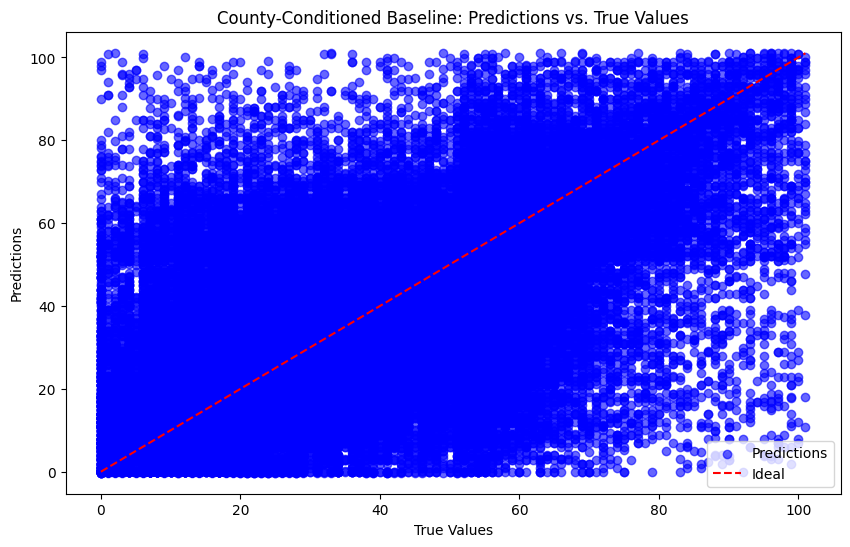

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedBaseline(nn.Module):
    def __init__(self, county_vocab_size, county_emb_dim=1):
        super(CountyConditionedBaseline, self).__init__()
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.global_bias = nn.Parameter(torch.zeros(1))

    def forward(self, x, county_id):
        last_value = x[:, -1, 0]
        county_bias = self.county_embedding(county_id).squeeze(1)
        return last_value + self.global_bias + county_bias

def train_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    county_vocab_size = len(dataset.county_to_id)
    print(f"Total samples: {len(dataset)}, Number of counties: {county_vocab_size}")

    train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CountyConditionedBaseline(county_vocab_size=county_vocab_size, county_emb_dim=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Starting training of the county-conditioned baseline model...")
    num_epochs = 10
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
    print("County-Conditioned Baseline Model Evaluation:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    torch.save(model.state_dict(), "county_conditioned_baseline.pt")
    print("Model parameters saved to county_conditioned_baseline.pt")

    plt.figure(figsize=(10,6))
    plt.scatter(trues, preds, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("County-Conditioned Baseline: Predictions vs. True Values")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

XGBoost (GPU) Performance:
RMSE: 14.31, MAE: 10.94


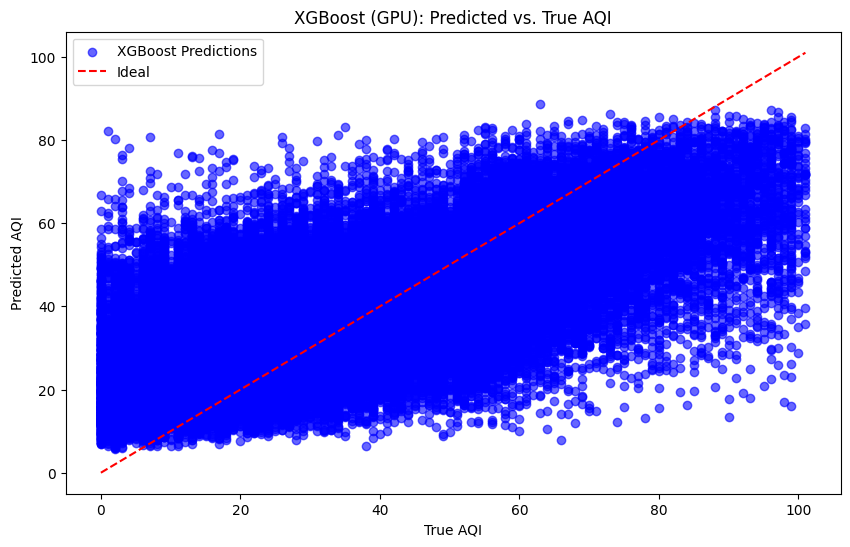

In [ ]:
def create_lagged_features(df, seq_length=30):
    rows = []
    for county, group in df.groupby("County"):
        group = group.sort_values("Date")
        series = group["Daily AQI Value"].values.astype(np.float32)
        if len(series) < seq_length + 1:
            continue
        for i in range(len(series) - seq_length):
            lag_features = series[i:i+seq_length]
            target = series[i+seq_length]
            rows.append(list(lag_features) + [target, county])
    columns = [f"lag_{i+1}" for i in range(seq_length)] + ["target", "county"]
    return pd.DataFrame(rows, columns=columns)

df = pd.read_csv("combined_aqi_data_iqr.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df = df.dropna(subset=["Daily AQI Value"])

lagged_df = create_lagged_features(df, seq_length=30)
lagged_df['county_id'] = lagged_df['county'].astype('category').cat.codes

feature_cols = [f"lag_{i+1}" for i in range(30)] + ["county_id"]
X = lagged_df[feature_cols].values
y = lagged_df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_xgb = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    tree_method='hist',
    device='cuda',
    random_state=42
)
model_xgb.fit(X_train, y_train)

preds = model_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
print("XGBoost (GPU) Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, preds, alpha=0.6, color='blue', label="XGBoost Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("XGBoost (GPU): Predicted vs. True AQI")
plt.legend()
plt.show()


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 24.3 MB/s eta 0:00:00


CatBoost (GPU) Performance:
RMSE: 14.28, MAE: 10.93


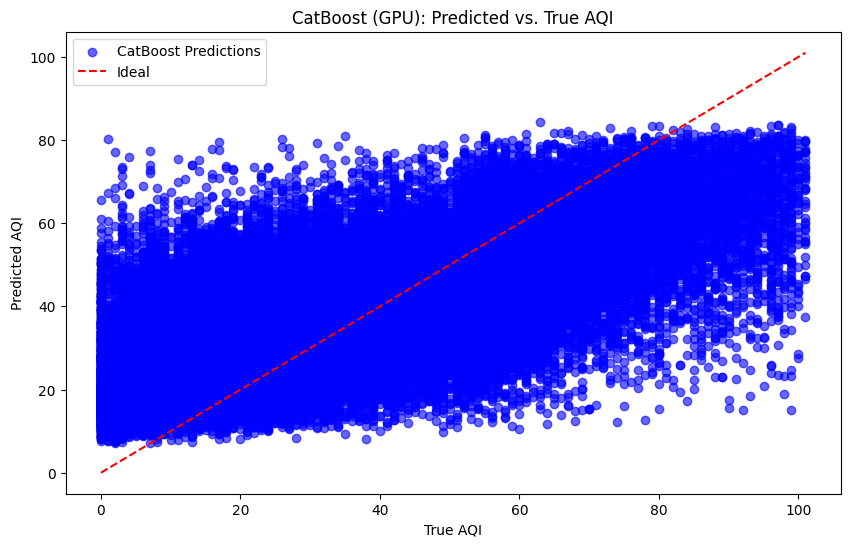

In [ ]:
def create_lagged_features(df, seq_length=30):
    rows = []
    for county, group in df.groupby("County"):
        group = group.sort_values("Date")
        series = group["Daily AQI Value"].values.astype(np.float32)
        if len(series) < seq_length + 1:
            continue
        for i in range(len(series) - seq_length):
            lag_features = series[i:i+seq_length]
            target = series[i+seq_length]
            rows.append(list(lag_features) + [target, county])
    columns = [f"lag_{i+1}" for i in range(seq_length)] + ["target", "county"]
    return pd.DataFrame(rows, columns=columns)

df = pd.read_csv("combined_aqi_data_iqr.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date')
df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
df = df.dropna(subset=["Daily AQI Value"])

lagged_df = create_lagged_features(df, seq_length=30)

lagged_df['county_id'] = lagged_df['county'].astype('category').cat.codes.astype(int)

feature_cols = [f"lag_{i+1}" for i in range(30)] + ["county_id"]
X = lagged_df[feature_cols]
y = lagged_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_cat = CatBoostRegressor(
    iterations=100,
    depth=5,
    learning_rate=0.1,
    loss_function='RMSE',
    task_type='GPU',
    devices='0',
    verbose=False,
    random_seed=42
)

cat_features = [30]
model_cat.fit(X_train, y_train, cat_features=cat_features)

preds_cat = model_cat.predict(X_test)

rmse_cat = np.sqrt(mean_squared_error(y_test, preds_cat))
mae_cat = mean_absolute_error(y_test, preds_cat)
print("CatBoost (GPU) Performance:")
print(f"RMSE: {rmse_cat:.2f}, MAE: {mae_cat:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, preds_cat, alpha=0.6, color='blue', label="CatBoost Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("CatBoost (GPU): Predicted vs. True AQI")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


cuML RandomForest (GPU) Performance:
RMSE: 14.64, MAE: 11.40


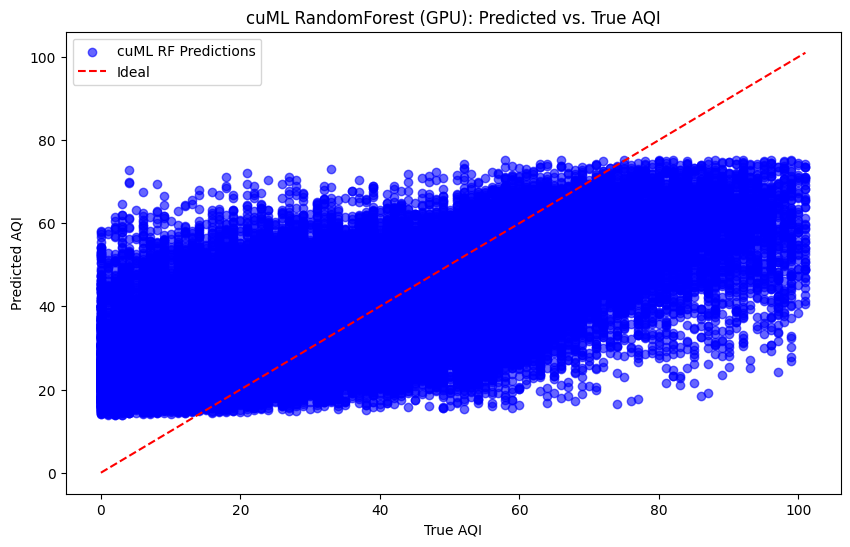

In [ ]:
def create_lagged_features(df, seq_length=30):
    rows = []
    for county, group in df.groupby("County"):
        group = group.sort_values("Date")
        series = group["Daily AQI Value"].values.astype(np.float32)
        if len(series) < seq_length + 1:
            continue
        for i in range(len(series) - seq_length):
            lag_features = series[i:i+seq_length]
            target = series[i+seq_length]
            rows.append(list(lag_features) + [target, county])
    columns = [f"lag_{i+1}" for i in range(seq_length)] + ["target", "county"]
    return pd.DataFrame(rows, columns=columns)

cdf = cudf.read_csv("combined_aqi_data_iqr.csv")
cdf['Date'] = cudf.to_datetime(cdf['Date'])
cdf = cdf.dropna(subset=['Date']).sort_values('Date')
cdf['Daily AQI Value'] = cdf['Daily AQI Value'].astype('float32')

pdf = cdf.to_pandas()

lagged_df = create_lagged_features(pdf, seq_length=30)
lagged_df['county_id'] = lagged_df['county'].astype('category').cat.codes

feature_cols = [f"lag_{i+1}" for i in range(30)] + ["county_id"]
X = lagged_df[feature_cols].values
y = lagged_df["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_cudf = cudf.DataFrame(X_train, columns=[f"f{i}" for i in range(X_train.shape[1])])
X_test_cudf = cudf.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])
y_train_cudf = cudf.Series(y_train)
y_test_cudf = cudf.Series(y_test)

rf_gpu = cuRF(n_estimators=100, max_depth=8, random_state=42)
rf_gpu.fit(X_train_cudf, y_train_cudf)

preds_gpu = rf_gpu.predict(X_test_cudf)

preds_gpu_np = preds_gpu.to_pandas().values
rmse_gpu = np.sqrt(mean_squared_error(y_test, preds_gpu_np))
mae_gpu = mean_absolute_error(y_test, preds_gpu_np)
print("cuML RandomForest (GPU) Performance:")
print(f"RMSE: {rmse_gpu:.2f}, MAE: {mae_gpu:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, preds_gpu_np, alpha=0.6, color='blue', label="cuML RF Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("cuML RandomForest (GPU): Predicted vs. True AQI")
plt.legend()
plt.show()


LSTM

Total samples: 534682
Number of counties: 52
Starting training of the county-conditioned LSTM model...
Epoch 1/20, Loss: 243.4708
Epoch 2/20, Loss: 203.8124
Epoch 3/20, Loss: 202.7680
Epoch 4/20, Loss: 202.0985
Epoch 5/20, Loss: 201.6276
Epoch 6/20, Loss: 201.2973
Epoch 7/20, Loss: 200.9682
Epoch 8/20, Loss: 200.6359
Epoch 9/20, Loss: 200.3509
Epoch 10/20, Loss: 200.0449
Epoch 11/20, Loss: 200.0774
Epoch 12/20, Loss: 199.7981
Epoch 13/20, Loss: 199.6990
Epoch 14/20, Loss: 199.4167
Epoch 15/20, Loss: 199.3144
Epoch 16/20, Loss: 199.0267
Epoch 17/20, Loss: 198.9764
Epoch 18/20, Loss: 198.7610
Epoch 19/20, Loss: 198.6170
Epoch 20/20, Loss: 198.5771
Evaluation on test set:
RMSE: 14.16, MAE: 10.79
Model parameters saved to hybrid_county_model.pt


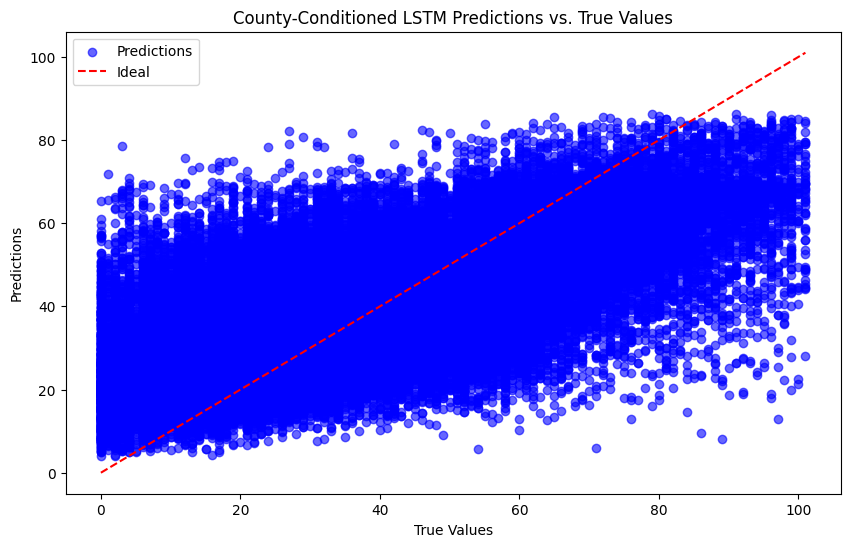

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM(nn.Module):
    def __init__(self, seq_length=30, input_size=1, lstm_hidden_size=64, lstm_layers=2,
                 county_vocab_size=10, county_emb_dim=16):
        super(CountyConditionedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, lstm_layers, batch_first=True)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.fc = nn.Linear(lstm_hidden_size + county_emb_dim, 1)

    def forward(self, x, county_id):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        county_emb = self.county_embedding(county_id)
        combined = torch.cat([last_hidden, county_emb], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)


def train_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    print(f"Total samples: {len(dataset)}")
    county_vocab_size = len(dataset.county_to_id)
    print(f"Number of counties: {county_vocab_size}")

    train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CountyConditionedLSTM(seq_length=seq_length, input_size=1, lstm_hidden_size=64,
                                    lstm_layers=2, county_vocab_size=county_vocab_size,
                                    county_emb_dim=16).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Starting training of the county-conditioned LSTM model...")
    num_epochs = 20
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
    print("Evaluation on test set:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    torch.save(model.state_dict(), "hybrid_county_model.pt")
    print("Model parameters saved to hybrid_county_model.pt")

    plt.figure(figsize=(10,6))
    plt.scatter(trues, preds, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("County-Conditioned LSTM Predictions vs. True Values")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Total samples: 534682
Number of counties: 52
Starting training (Version 1: Dropout + Weight Decay)...
Epoch 1/20, Loss: 278.2024
Epoch 2/20, Loss: 230.5390
Epoch 3/20, Loss: 226.1986
Epoch 4/20, Loss: 222.9416
Epoch 5/20, Loss: 220.1528
Epoch 6/20, Loss: 218.2685
Epoch 7/20, Loss: 216.6846
Epoch 8/20, Loss: 215.3422
Epoch 9/20, Loss: 213.9761
Epoch 10/20, Loss: 213.1978
Epoch 11/20, Loss: 212.2229
Epoch 12/20, Loss: 211.4324
Epoch 13/20, Loss: 210.7360
Epoch 14/20, Loss: 210.0371
Epoch 15/20, Loss: 209.9206
Epoch 16/20, Loss: 209.5441
Epoch 17/20, Loss: 208.8730
Epoch 18/20, Loss: 208.6875
Epoch 19/20, Loss: 208.4459
Epoch 20/20, Loss: 208.2883
Evaluation on test set:
RMSE: 14.14, MAE: 10.85
Model parameters saved to model_dropout_weightdecay.pt


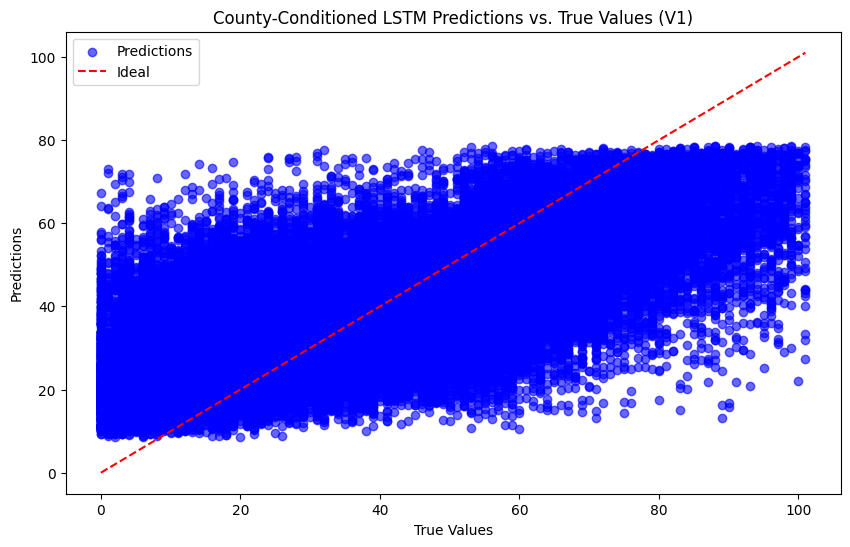

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date']).sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM(nn.Module):
    def __init__(self, seq_length=30, input_size=1, lstm_hidden_size=64, lstm_layers=2,
                 county_vocab_size=10, county_emb_dim=16, dropout_prob=0.5):
        super(CountyConditionedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, lstm_layers,
                            batch_first=True, dropout=dropout_prob if lstm_layers > 1 else 0.0)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(lstm_hidden_size + county_emb_dim, 1)

    def forward(self, x, county_id):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        county_emb = self.county_embedding(county_id)
        combined = torch.cat([last_hidden, county_emb], dim=1)
        combined = self.dropout(combined)
        out = self.fc(combined)
        return out.squeeze(1)

def train_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    print(f"Total samples: {len(dataset)}")
    county_vocab_size = len(dataset.county_to_id)
    print(f"Number of counties: {county_vocab_size}")

    train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CountyConditionedLSTM(seq_length=seq_length, input_size=1, lstm_hidden_size=64,
                                    lstm_layers=2, county_vocab_size=county_vocab_size,
                                    county_emb_dim=16, dropout_prob=0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    print("Starting training (Version 1: Dropout + Weight Decay)...")
    train_model(model, train_loader, criterion, optimizer, num_epochs=20, device=device)

    preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
    print("Evaluation on test set:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    torch.save(model.state_dict(), "model_dropout_weightdecay.pt")
    print("Model parameters saved to model_dropout_weightdecay.pt")

    plt.figure(figsize=(10,6))
    plt.scatter(trues, preds, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("County-Conditioned LSTM Predictions vs. True Values (V1)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Total samples: 534682
Number of counties: 52
Starting training with Early Stopping & EMA smoothing (Version 2)...
Epoch 1/50 | Train Loss: 288.0048 | Val Loss: 204.8581
Epoch 2/50 | Train Loss: 232.0868 | Val Loss: 206.3797
Epoch 3/50 | Train Loss: 227.7290 | Val Loss: 203.9775
Epoch 4/50 | Train Loss: 224.3229 | Val Loss: 201.8055
Epoch 5/50 | Train Loss: 222.3950 | Val Loss: 201.4734
Epoch 6/50 | Train Loss: 220.5028 | Val Loss: 201.8241
Epoch 7/50 | Train Loss: 218.5330 | Val Loss: 202.4946
Epoch 8/50 | Train Loss: 216.8750 | Val Loss: 203.1701
Epoch 9/50 | Train Loss: 216.1585 | Val Loss: 200.9912
Epoch 10/50 | Train Loss: 215.1035 | Val Loss: 200.8316
Epoch 11/50 | Train Loss: 214.1502 | Val Loss: 204.5113
Epoch 12/50 | Train Loss: 213.0852 | Val Loss: 202.0208
Epoch 13/50 | Train Loss: 212.5464 | Val Loss: 202.8128
Epoch 14/50 | Train Loss: 211.7267 | Val Loss: 201.5869
Epoch 15/50 | Train Loss: 211.4103 | Val Loss: 201.0794
Early stopping triggered.
Evaluation on test set:
RMSE:

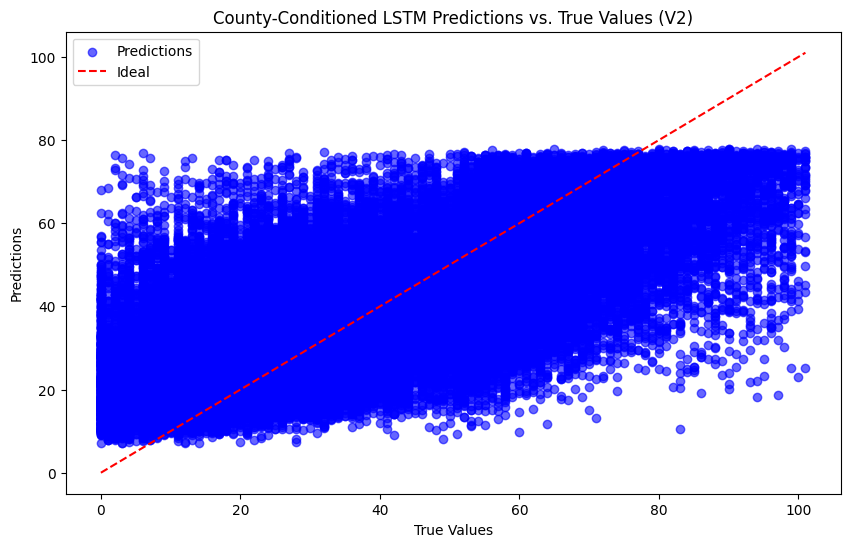

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date']).sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

class CountyConditionedLSTM(nn.Module):
    def __init__(self, seq_length=30, input_size=1, lstm_hidden_size=64, lstm_layers=2,
                 county_vocab_size=10, county_emb_dim=16, dropout_prob=0.5):
        super(CountyConditionedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, lstm_layers,
                            batch_first=True, dropout=dropout_prob if lstm_layers > 1 else 0.0)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(lstm_hidden_size + county_emb_dim, 1)

    def forward(self, x, county_id):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        county_emb = self.county_embedding(county_id)
        combined = torch.cat([last_hidden, county_emb], dim=1)
        combined = self.dropout(combined)
        out = self.fc(combined)
        return out.squeeze(1)


def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                                    num_epochs=50, device="cuda", patience=5, ema_decay=0.99):
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    ema_model = CountyConditionedLSTM(seq_length=30, input_size=1, lstm_hidden_size=64, lstm_layers=2,
                                        county_vocab_size=model.county_embedding.num_embeddings,
                                        county_emb_dim=model.county_embedding.embedding_dim, dropout_prob=0.5).to(device)
    ema_model.load_state_dict(model.state_dict())

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for seq, target, county_id in train_loader:
            seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                for param, ema_param in zip(model.parameters(), ema_model.parameters()):
                    ema_param.copy_(ema_decay * ema_param + (1 - ema_decay) * param)
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for seq, target, county_id in val_loader:
                seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
                pred = model(seq, county_id)
                loss = criterion(pred, target)
                val_loss += loss.item() * seq.size(0)
        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    print(f"Total samples: {len(dataset)}")
    county_vocab_size = len(dataset.county_to_id)
    print(f"Number of counties: {county_vocab_size}")

    full_train, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CountyConditionedLSTM(seq_length=seq_length, input_size=1, lstm_hidden_size=64,
                                    lstm_layers=2, county_vocab_size=county_vocab_size,
                                    county_emb_dim=16, dropout_prob=0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print("Starting training with Early Stopping & EMA smoothing (Version 2)...")
    model = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                                              num_epochs=50, device=device, patience=5, ema_decay=0.99)

    preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
    print("Evaluation on test set:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    torch.save(model.state_dict(), "model_earlystop_ema.pt")
    print("Model parameters saved to model_earlystop_ema.pt")

    plt.figure(figsize=(10,6))
    plt.scatter(trues, preds, alpha=0.6, color='blue', label="Predictions")
    plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("County-Conditioned LSTM Predictions vs. True Values (V2)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

Total samples: 534682
Number of counties: 52
Starting ensemble training (Version 3: Ensemble with Dropout + Weight Decay)...

Training model 1/3:
Epoch 1/20, Loss: 275.7150
Epoch 2/20, Loss: 230.3799
Epoch 3/20, Loss: 225.0656
Epoch 4/20, Loss: 222.3034
Epoch 5/20, Loss: 219.6095
Epoch 6/20, Loss: 218.0722
Epoch 7/20, Loss: 216.4534
Epoch 8/20, Loss: 214.7427
Epoch 9/20, Loss: 214.0000
Epoch 10/20, Loss: 212.9605
Epoch 11/20, Loss: 211.9515
Epoch 12/20, Loss: 211.4057
Epoch 13/20, Loss: 210.9652
Epoch 14/20, Loss: 210.2380
Epoch 15/20, Loss: 209.6920
Epoch 16/20, Loss: 209.0568
Epoch 17/20, Loss: 208.9507
Epoch 18/20, Loss: 208.2704
Epoch 19/20, Loss: 207.8710
Epoch 20/20, Loss: 207.7035

Training model 2/3:
Epoch 1/20, Loss: 276.3492
Epoch 2/20, Loss: 230.0155
Epoch 3/20, Loss: 225.6811
Epoch 4/20, Loss: 222.5356
Epoch 5/20, Loss: 219.9381
Epoch 6/20, Loss: 218.3336
Epoch 7/20, Loss: 216.6427
Epoch 8/20, Loss: 214.9886
Epoch 9/20, Loss: 213.9438
Epoch 10/20, Loss: 212.7100
Epoch 11/20

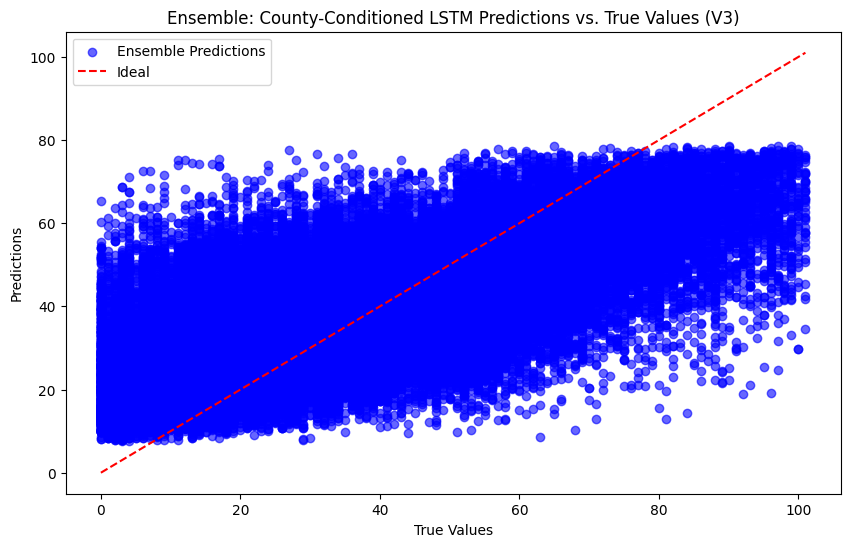

In [ ]:
class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date']).sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM(nn.Module):
    def __init__(self, seq_length=30, input_size=1, lstm_hidden_size=64, lstm_layers=2,
                 county_vocab_size=10, county_emb_dim=16, dropout_prob=0.5):
        super(CountyConditionedLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_hidden_size, lstm_layers,
                            batch_first=True, dropout=dropout_prob if lstm_layers > 1 else 0.0)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(lstm_hidden_size + county_emb_dim, 1)

    def forward(self, x, county_id):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        county_emb = self.county_embedding(county_id)
        combined = torch.cat([last_hidden, county_emb], dim=1)
        combined = self.dropout(combined)
        out = self.fc(combined)
        return out.squeeze(1)

def train_single_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq, target, county_id = seq.to(device), target.to(device), county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return model

def ensemble_evaluate(models, dataloader, device="cuda"):
    for m in models:
        m.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq, county_id = seq.to(device), county_id.to(device)
            preds = []
            for m in models:
                pred = m(seq, county_id)
                preds.append(pred.cpu().numpy())
            avg_pred = np.mean(preds, axis=0)
            predictions.extend(avg_pred)
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    csv_file = "combined_aqi_data_iqr.csv"
    seq_length = 30
    dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
    print(f"Total samples: {len(dataset)}")
    county_vocab_size = len(dataset.county_to_id)
    print(f"Number of counties: {county_vocab_size}")

    train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

    ensemble_size = 3
    models = []
    criterion = nn.MSELoss()

    print("Starting ensemble training (Version 3: Ensemble with Dropout + Weight Decay)...")
    for i in range(ensemble_size):
        print(f"\nTraining model {i+1}/{ensemble_size}:")
        model = CountyConditionedLSTM(seq_length=seq_length, input_size=1, lstm_hidden_size=64,
                                        lstm_layers=2, county_vocab_size=county_vocab_size,
                                        county_emb_dim=16, dropout_prob=0.5).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        model = train_single_model(model, train_loader, criterion, optimizer, num_epochs=20, device=device)
        models.append(model)

    preds, trues, rmse, mae = ensemble_evaluate(models, test_loader, device=device)
    print("\nEnsemble Evaluation on test set:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

    torch.save([m.state_dict() for m in models], "ensemble_models.pt")
    print("Ensemble model parameters saved to ensemble_models.pt")

    plt.figure(figsize=(10,6))
    plt.scatter(trues, preds, alpha=0.6, color='blue', label="Ensemble Predictions")
    plt.plot([min(trues), max(trues)], [min(trues), max(trues)], color='red', linestyle='--', label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title("Ensemble: County-Conditioned LSTM Predictions vs. True Values (V3)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

GNN with Geographical Data

In [ ]:
import pandas as pd

filenames = []
for i in range(1, 11):
    if i == 1:
        filenames.append("ad_viz_plotval_data.csv")
    else:
        filenames.append(f"ad_viz_plotval_data-{i}.csv")

dfs = []
for file in filenames:
    try:
        df = pd.read_csv(file)
        dfs.append(df)
        print(f"Loaded {file} with {len(df)} rows.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"\nTotal combined rows: {len(combined_df)}")

combined_df["Site Latitude"] = pd.to_numeric(combined_df["Site Latitude"], errors="coerce")
combined_df["Site Longitude"] = pd.to_numeric(combined_df["Site Longitude"], errors="coerce")

combined_df = combined_df.dropna(subset=["Site Latitude", "Site Longitude"])

county_geo = combined_df.groupby("County")[["Site Latitude", "Site Longitude"]].mean().reset_index()

county_geo = county_geo.rename(columns={"Site Latitude": "Mean Latitude", "Site Longitude": "Mean Longitude"})

county_geo.to_csv("county_geography.csv", index=False)
print("\ncounty_geography.csv has been created with the combined data from all 10 files.")


Loaded ad_viz_plotval_data.csv with 54939 rows.
Loaded ad_viz_plotval_data-2.csv with 58941 rows.
Loaded ad_viz_plotval_data-3.csv with 59921 rows.
Loaded ad_viz_plotval_data-4.csv with 59776 rows.
Loaded ad_viz_plotval_data-5.csv with 57520 rows.
Loaded ad_viz_plotval_data-6.csv with 54858 rows.
Loaded ad_viz_plotval_data-7.csv with 52833 rows.
Loaded ad_viz_plotval_data-8.csv with 49666 rows.
Loaded ad_viz_plotval_data-9.csv with 49500 rows.
Loaded ad_viz_plotval_data-10.csv with 47889 rows.

Total combined rows: 545843

county_geography.csv has been created with the combined data from all 10 files.


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00


Number of counties (from geography): 52
GNN Epoch 10/50, Loss: 2.3673
GNN Epoch 20/50, Loss: 1.2901
GNN Epoch 30/50, Loss: 0.5603
GNN Epoch 40/50, Loss: 0.2963
GNN Epoch 50/50, Loss: 0.1377
County embeddings saved to county_geography_embeddings.pt
Total samples: 534682, Number of counties: 52


<ipython-input-13-3ff904e4fa47>:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  county_embeddings = torch.load("county_geography_embeddings.pt", map_location=device)


Epoch 1/20, Loss: 220.9336
Epoch 2/20, Loss: 209.5108
Epoch 3/20, Loss: 208.9122
Epoch 4/20, Loss: 209.0227
Epoch 5/20, Loss: 208.7311
Epoch 6/20, Loss: 208.4474
Epoch 7/20, Loss: 208.3830
Epoch 8/20, Loss: 208.1963
Epoch 9/20, Loss: 208.2327
Epoch 10/20, Loss: 207.7553
Epoch 11/20, Loss: 207.3267
Epoch 12/20, Loss: 207.6641
Epoch 13/20, Loss: 209.1642
Epoch 14/20, Loss: 210.9967
Epoch 15/20, Loss: 209.1962
Epoch 16/20, Loss: 208.7413
Epoch 17/20, Loss: 208.4318
Epoch 18/20, Loss: 208.8731
Epoch 19/20, Loss: 208.2272
Epoch 20/20, Loss: 207.7095
County-Conditioned LSTM with GNN Embeddings Evaluation:
RMSE: 14.33, MAE: 10.94


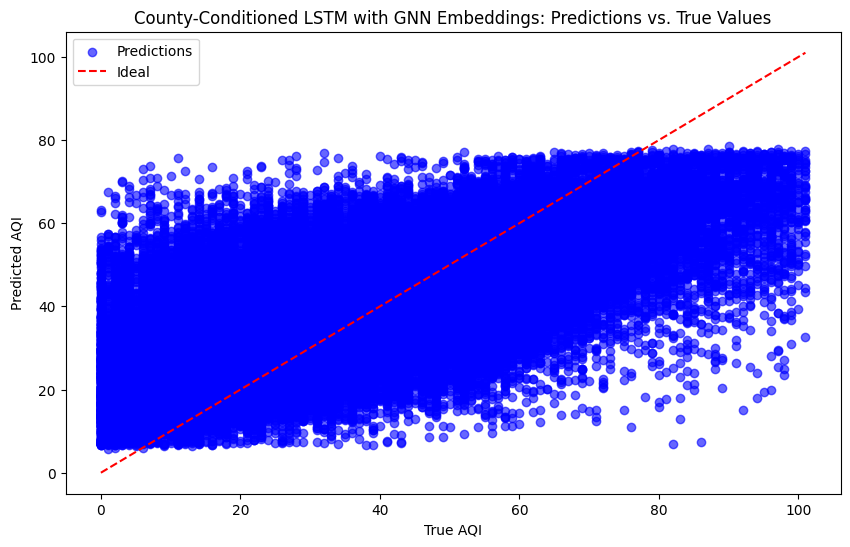

In [ ]:
geo_df = pd.read_csv("county_geography.csv")
geo_df["Mean Latitude"] = (geo_df["Mean Latitude"] - geo_df["Mean Latitude"].mean()) / geo_df["Mean Latitude"].std()
geo_df["Mean Longitude"] = (geo_df["Mean Longitude"] - geo_df["Mean Longitude"].mean()) / geo_df["Mean Longitude"].std()

county_to_idx = {row["County"]: idx for idx, row in geo_df.iterrows()}
print("Number of counties (from geography):", len(county_to_idx))

import torch
x = torch.tensor(geo_df[["Mean Latitude", "Mean Longitude"]].values, dtype=torch.float)

from sklearn.neighbors import NearestNeighbors
k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(x.numpy())
distances, indices = nbrs.kneighbors(x.numpy())

edge_index = []
for i in range(x.size(0)):
    for j in indices[i][1:]:
        edge_index.append([i, j])
        edge_index.append([j, i])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index)

from torch_geometric.nn import GCNConv

class CountyGNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, output_dim=16):
        super(CountyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
gnn = CountyGNN(input_dim=2, hidden_dim=16, output_dim=16).to(device)
optimizer_gnn = optim.Adam(gnn.parameters(), lr=0.01)
gnn.train()
for epoch in range(50):
    optimizer_gnn.zero_grad()
    out = gnn(data.to(device))
    loss = out.norm(2)
    loss.backward()
    optimizer_gnn.step()
    if (epoch+1) % 10 == 0:
        print(f"GNN Epoch {epoch+1}/50, Loss: {loss.item():.4f}")
gnn.eval()
with torch.no_grad():
    county_embeddings = gnn(data.to(device))
torch.save(county_embeddings, "county_geography_embeddings.pt")
print("County embeddings saved to county_geography_embeddings.pt")


class CountyAQIDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])
        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}
        self.seq_length = seq_length
        self.samples = []
        for county, group in df.groupby("County"):
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, self.county_to_id[county]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM_GNN(nn.Module):
    def __init__(self, seq_length=30, input_size=1, hidden_size=100, lstm_layers=1, gnn_emb_dim=16):
        super(CountyConditionedLSTM_GNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size + gnn_emb_dim, 1)

    def forward(self, x, county_idx, county_embeddings):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        county_emb = county_embeddings[county_idx]
        combined = torch.cat([last_hidden, county_emb], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)


device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30

dataset = CountyAQIDataset(csv_file, seq_length=seq_length)
train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Total samples: {len(dataset)}, Number of counties: {len(dataset.county_to_id)}")

county_embeddings = torch.load("county_geography_embeddings.pt", map_location=device)
county_embeddings = county_embeddings.to(device)

model_forecast = CountyConditionedLSTM_GNN(seq_length=seq_length, input_size=1, hidden_size=100, lstm_layers=1, gnn_emb_dim=16).to(device)
criterion = nn.MSELoss()
optimizer_forecast = optim.Adam(model_forecast.parameters(), lr=0.003958338172663681, weight_decay=1e-4)

num_epochs = 20
model_forecast.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for seq, target, county_idx in train_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        optimizer_forecast.zero_grad()
        pred = model_forecast(seq, county_idx, county_embeddings)
        loss = criterion(pred, target)
        loss.backward()
        optimizer_forecast.step()
        epoch_loss += loss.item() * seq.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model_forecast.eval()
predictions = []
targets = []
with torch.no_grad():
    for seq, target, county_idx in test_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        pred = model_forecast(seq, county_idx, county_embeddings)
        predictions.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
print("County-Conditioned LSTM with GNN Embeddings Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(10,6))
plt.scatter(targets, predictions, alpha=0.6, color='blue', label="Predictions")
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("County-Conditioned LSTM with GNN Embeddings: Predictions vs. True Values")
plt.legend()
plt.show()


<ipython-input-14-87d8eb201f55>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  county_embeddings = torch.load("county_geography_embeddings.pt", map_location="cuda" if tor

Total samples: 534682, Number of counties: 52
Epoch 1/20, Loss: 231.6831
Epoch 2/20, Loss: 203.3603
Epoch 3/20, Loss: 202.2810
Epoch 4/20, Loss: 201.5952
Epoch 5/20, Loss: 201.1756
Epoch 6/20, Loss: 200.9143
Epoch 7/20, Loss: 200.5239
Epoch 8/20, Loss: 200.2175
Epoch 9/20, Loss: 199.9094
Epoch 10/20, Loss: 199.6685
Epoch 11/20, Loss: 199.4494
Epoch 12/20, Loss: 199.3166
Epoch 13/20, Loss: 199.1151
Epoch 14/20, Loss: 199.1511
Epoch 15/20, Loss: 198.8801
Epoch 16/20, Loss: 198.7306
Epoch 17/20, Loss: 198.5680
Epoch 18/20, Loss: 198.4206
Epoch 19/20, Loss: 198.3388
Epoch 20/20, Loss: 198.3265
County-Conditioned LSTM with GNN Neighbor Context Evaluation:
RMSE: 14.13, MAE: 10.86
Model parameters saved to county_conditioned_lstm_gnncontext.pt


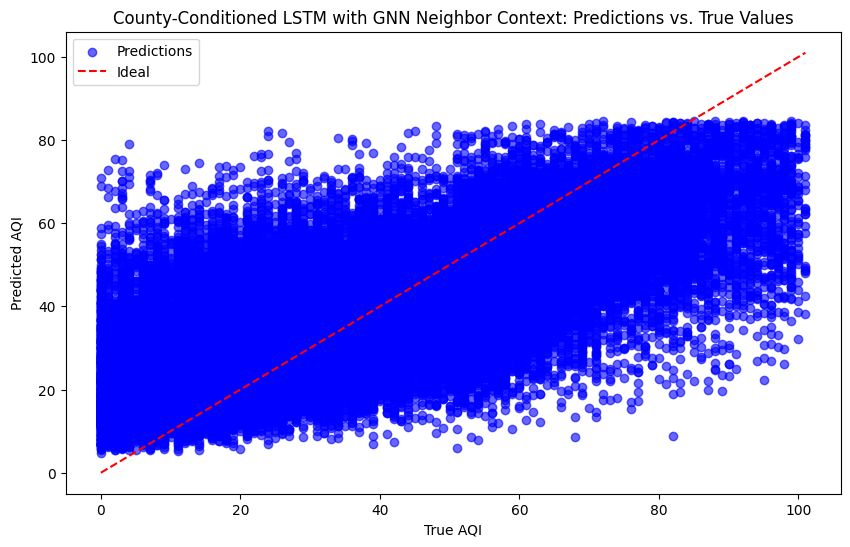

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F


geo_df = pd.read_csv("county_geography.csv")
geo_df["Mean Latitude"] = (geo_df["Mean Latitude"] - geo_df["Mean Latitude"].mean()) / geo_df["Mean Latitude"].std()
geo_df["Mean Longitude"] = (geo_df["Mean Longitude"] - geo_df["Mean Longitude"].mean()) / geo_df["Mean Longitude"].std()

geo_features = geo_df[["Mean Latitude", "Mean Longitude"]].values

k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(geo_features)
distances, indices = nbrs.kneighbors(geo_features)

neighbor_indices = {}
num_counties = geo_df.shape[0]
for i in range(num_counties):
    neighbor_indices[i] = indices[i][1:].tolist()

county_embeddings = torch.load("county_geography_embeddings.pt", map_location="cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
county_embeddings = county_embeddings.to(device)

class CountyAQIDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])
        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}
        self.seq_length = seq_length
        self.samples = []
        for county, group in df.groupby("County"):
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, self.county_to_id[county]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM_GNNContext(nn.Module):
    def __init__(self, seq_length=30, input_size=1, hidden_size=100, lstm_layers=1, gnn_emb_dim=16, context_proj_dim=32):
        super(CountyConditionedLSTM_GNNContext, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.context_proj = nn.Linear(gnn_emb_dim * 2, context_proj_dim)
        self.fc = nn.Linear(hidden_size + context_proj_dim, 1)

    def forward(self, x, county_idx, county_embeddings, neighbor_indices):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]

        batch_context = []
        for idx in county_idx.cpu().numpy():
            own_emb = county_embeddings[idx]
            neigh_idx = neighbor_indices[idx]
            neighbor_embs = county_embeddings[neigh_idx]
            avg_neigh_emb = neighbor_embs.mean(dim=0)
            combined = torch.cat([own_emb, avg_neigh_emb], dim=0)
            batch_context.append(combined)
        batch_context = torch.stack(batch_context).to(x.device)
        context = torch.relu(self.context_proj(batch_context))
        combined_features = torch.cat([last_hidden, context], dim=1)
        out = self.fc(combined_features)
        return out.squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30

dataset = CountyAQIDataset(csv_file, seq_length=seq_length)
train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Total samples: {len(dataset)}, Number of counties: {len(dataset.county_to_id)}")

model = CountyConditionedLSTM_GNNContext(seq_length=seq_length, input_size=1, hidden_size=100, lstm_layers=2,
                                           gnn_emb_dim=16, context_proj_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for seq, target, county_idx in train_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        optimizer.zero_grad()
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * seq.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
predictions = []
targets = []
with torch.no_grad():
    for seq, target, county_idx in test_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        predictions.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
print("County-Conditioned LSTM with GNN Neighbor Context Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

torch.save(model.state_dict(), "county_conditioned_lstm_gnncontext.pt")
print("Model parameters saved to county_conditioned_lstm_gnncontext.pt")

plt.figure(figsize=(10,6))
plt.scatter(targets, predictions, alpha=0.6, color='blue', label="Predictions")
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("County-Conditioned LSTM with GNN Neighbor Context: Predictions vs. True Values")
plt.legend()
plt.show()


<ipython-input-21-0ffe375be7e7>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  county_embeddings = torch.load("county_geography_embeddings.pt", map_location="cuda" if tor

Total samples: 534682, Number of counties: 52
Epoch 1/20, Loss: 231.4460
Epoch 2/20, Loss: 204.5250
Epoch 3/20, Loss: 203.5975
Epoch 4/20, Loss: 202.7674
Epoch 5/20, Loss: 202.3515
Epoch 6/20, Loss: 201.9874
Epoch 7/20, Loss: 201.6381
Epoch 8/20, Loss: 201.2856
Epoch 9/20, Loss: 201.0693
Epoch 10/20, Loss: 200.7268
Epoch 11/20, Loss: 200.6338
Epoch 12/20, Loss: 200.5648
Epoch 13/20, Loss: 200.5003
Epoch 14/20, Loss: 200.1035
Epoch 15/20, Loss: 199.9475
Epoch 16/20, Loss: 199.8273
Epoch 17/20, Loss: 199.6301
Epoch 18/20, Loss: 199.7530
Epoch 19/20, Loss: 199.4867
Epoch 20/20, Loss: 199.2329
County-Conditioned LSTM with GNN Neighbor Context Evaluation:
RMSE: 14.10, MAE: 10.84
Model parameters saved to county_conditioned_lstm_gnncontext.pt


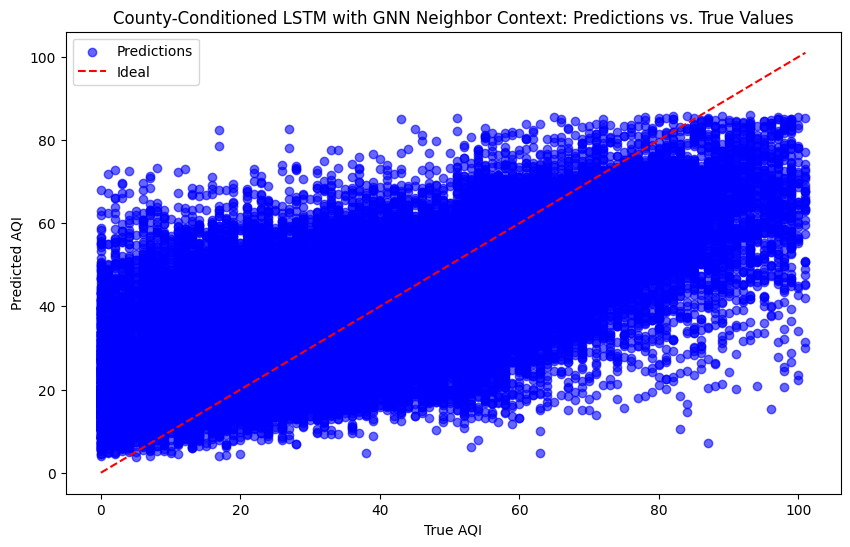

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F

geo_df = pd.read_csv("county_geography.csv")
geo_df["Mean Latitude"] = (geo_df["Mean Latitude"] - geo_df["Mean Latitude"].mean()) / geo_df["Mean Latitude"].std()
geo_df["Mean Longitude"] = (geo_df["Mean Longitude"] - geo_df["Mean Longitude"].mean()) / geo_df["Mean Longitude"].std()

geo_features = geo_df[["Mean Latitude", "Mean Longitude"]].values

k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(geo_features)
distances, indices = nbrs.kneighbors(geo_features)

neighbor_indices = {}
num_counties = geo_df.shape[0]
for i in range(num_counties):
    neighbor_indices[i] = indices[i][1:].tolist()

county_embeddings = torch.load("county_geography_embeddings.pt", map_location="cuda" if torch.cuda.is_available() else "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
county_embeddings = county_embeddings.to(device)


class CountyAQIDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])
        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}
        self.seq_length = seq_length
        self.samples = []
        for county, group in df.groupby("County"):
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, self.county_to_id[county]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM_GNNContext_Attn(nn.Module):
    def __init__(self, seq_length=30, input_size=1, hidden_size=100, lstm_layers=1, gnn_emb_dim=16, context_proj_dim=32):
        super(CountyConditionedLSTM_GNNContext_Attn, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.context_proj = nn.Linear(gnn_emb_dim * 2, context_proj_dim)
        self.fc = nn.Linear(hidden_size + context_proj_dim, 1)

    def forward(self, x, county_idx, county_embeddings, neighbor_indices):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        batch_context = []
        for idx in county_idx.cpu().numpy():
            own_emb = county_embeddings[idx]
            neigh_idx = neighbor_indices[idx]
            neighbor_embs = county_embeddings[neigh_idx]
            attn_scores = torch.matmul(neighbor_embs, own_emb.unsqueeze(-1)).squeeze(-1)
            attn_weights = torch.softmax(attn_scores, dim=0)
            weighted_neigh_emb = (neighbor_embs * attn_weights.unsqueeze(-1)).sum(dim=0)
            combined_emb = torch.cat([own_emb, weighted_neigh_emb], dim=0)
            batch_context.append(combined_emb)
        batch_context = torch.stack(batch_context).to(x.device)
        context = torch.relu(self.context_proj(batch_context))
        combined_features = torch.cat([last_hidden, context], dim=1)
        out = self.fc(combined_features)
        return out.squeeze(1)


device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30

dataset = CountyAQIDataset(csv_file, seq_length=seq_length)
train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Total samples: {len(dataset)}, Number of counties: {len(dataset.county_to_id)}")

model = CountyConditionedLSTM_GNNContext(seq_length=seq_length, input_size=1, hidden_size=100, lstm_layers=2,
                                           gnn_emb_dim=16, context_proj_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for seq, target, county_idx in train_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        optimizer.zero_grad()
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * seq.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
predictions = []
targets = []
with torch.no_grad():
    for seq, target, county_idx in test_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        predictions.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

rmse = np.sqrt(mean_squared_error(targets, predictions))
mae = mean_absolute_error(targets, predictions)
print("County-Conditioned LSTM with GNN Neighbor Context Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

torch.save(model.state_dict(), "county_conditioned_lstm_gnncontext.pt")
print("Model parameters saved to county_conditioned_lstm_gnncontext.pt")

plt.figure(figsize=(10,6))
plt.scatter(targets, predictions, alpha=0.6, color='blue', label="Predictions")
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--', label="Ideal")
plt.xlabel("True AQI")
plt.ylabel("Predicted AQI")
plt.title("County-Conditioned LSTM with GNN Neighbor Context: Predictions vs. True Values")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import GAE
from sklearn.neighbors import NearestNeighbors

geo_df = pd.read_csv("county_geography.csv")
geo_df["Mean Latitude"] = (geo_df["Mean Latitude"] - geo_df["Mean Latitude"].mean()) / geo_df["Mean Latitude"].std()
geo_df["Mean Longitude"] = (geo_df["Mean Longitude"] - geo_df["Mean Longitude"].mean()) / geo_df["Mean Longitude"].std()

x = torch.tensor(geo_df[["Mean Latitude", "Mean Longitude"]].values, dtype=torch.float)


k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(x.numpy())
distances, indices = nbrs.kneighbors(x.numpy())

edge_index = []
num_nodes = x.size(0)
for i in range(num_nodes):
    for j in indices[i][1:]:
        edge_index.append([i, j])
        edge_index.append([j, i])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

data = Data(x=x, edge_index=edge_index)
print(f"Graph has {data.num_nodes} nodes and {data.num_edges} edges.")


class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

in_channels = 2
hidden_channels = 16
out_channels = 16

encoder = GCNEncoder(in_channels, hidden_channels, out_channels)
model = GAE(encoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


model.train()
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


model.eval()
with torch.no_grad():
    county_embeddings = model.encode(data.x, data.edge_index)
print("County embeddings shape:", county_embeddings.shape)
torch.save(county_embeddings, "county_geography_embeddings.pt")
print("County embeddings saved to county_geography_embeddings.pt")


Graph has 52 nodes and 312 edges.
Epoch 20/200, Loss: 0.9859
Epoch 40/200, Loss: 0.9415
Epoch 60/200, Loss: 0.8991
Epoch 80/200, Loss: 0.9394
Epoch 100/200, Loss: 0.8739
Epoch 120/200, Loss: 0.9140
Epoch 140/200, Loss: 0.8809
Epoch 160/200, Loss: 0.9325
Epoch 180/200, Loss: 0.9501
Epoch 200/200, Loss: 0.9045
County embeddings shape: torch.Size([52, 16])
County embeddings saved to county_geography_embeddings.pt


<ipython-input-4-9cca06364395>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  county_embeddings = torch.load("county_geography_embeddings.pt", map_location=device)


Total samples: 534682, Number of counties: 52
Training County-Conditioned LSTM with GNN Neighbor Context and Attention...
Epoch 1/20, Loss: 231.8280
Epoch 2/20, Loss: 203.6893
Epoch 3/20, Loss: 202.4579
Epoch 4/20, Loss: 201.9427
Epoch 5/20, Loss: 201.2897
Epoch 6/20, Loss: 201.0968
Epoch 7/20, Loss: 200.5860
Epoch 8/20, Loss: 200.4295
Epoch 9/20, Loss: 200.2425
Epoch 10/20, Loss: 199.9590
Epoch 11/20, Loss: 199.8430
Epoch 12/20, Loss: 199.6157
Epoch 13/20, Loss: 199.3737
Epoch 14/20, Loss: 199.1751
Epoch 15/20, Loss: 198.9136
Epoch 16/20, Loss: 198.8685
Epoch 17/20, Loss: 198.4862
Epoch 18/20, Loss: 198.3335
Epoch 19/20, Loss: 198.3027
Epoch 20/20, Loss: 198.0836
Overall Evaluation:
RMSE: 14.19, MAE: 10.90
Model parameters saved to county_conditioned_lstm_gnncontext.pt
Per-County Evaluation Metrics:
             County       RMSE        MAE  n_samples
0      Contra Costa  13.014291  10.332226       1451
1         Riverside  15.102291  11.883065       8406
2             Butte  14.95161

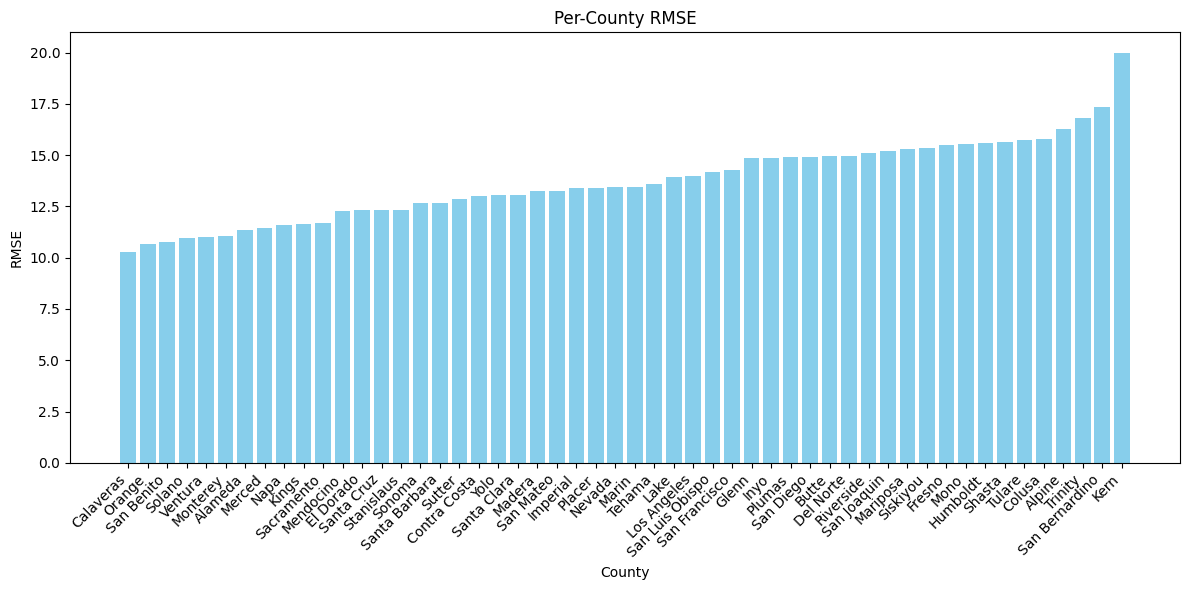

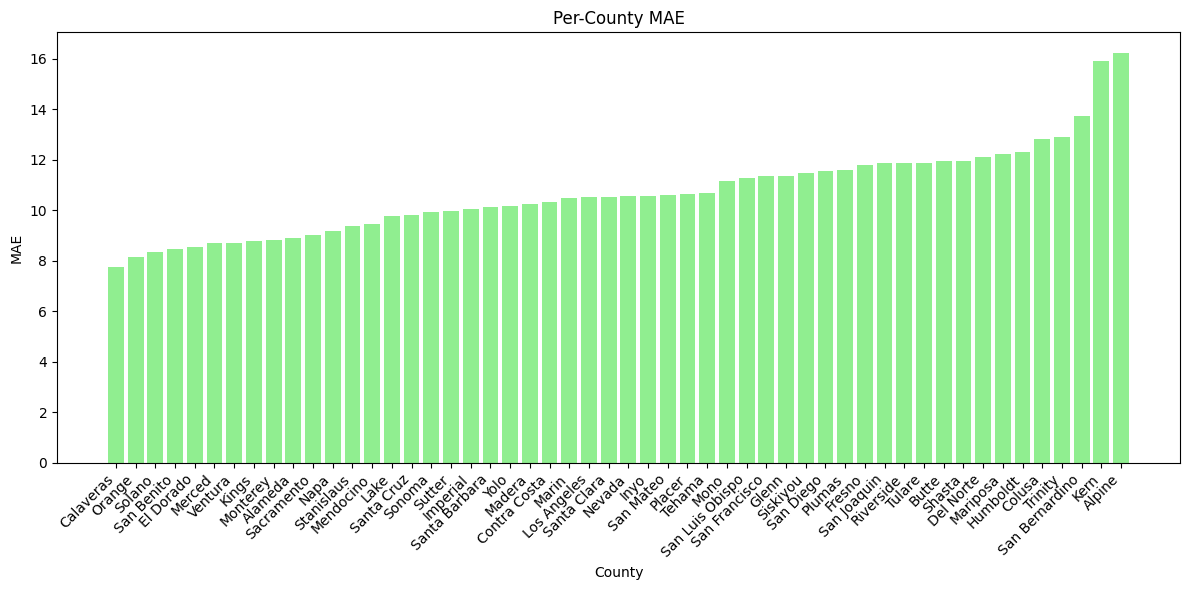

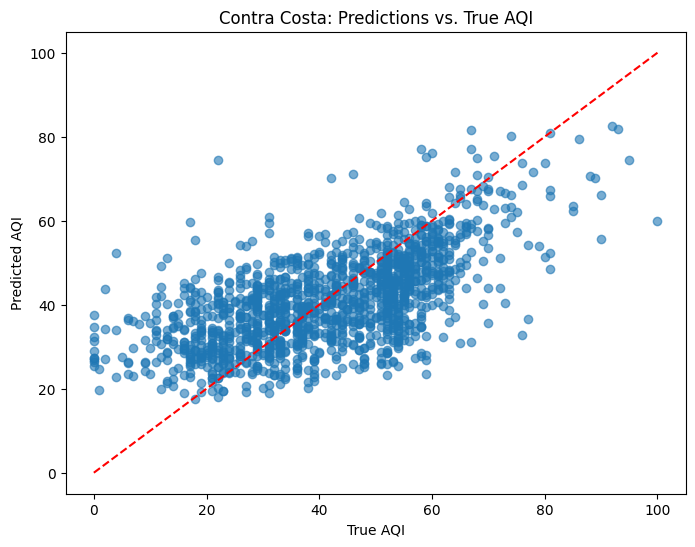

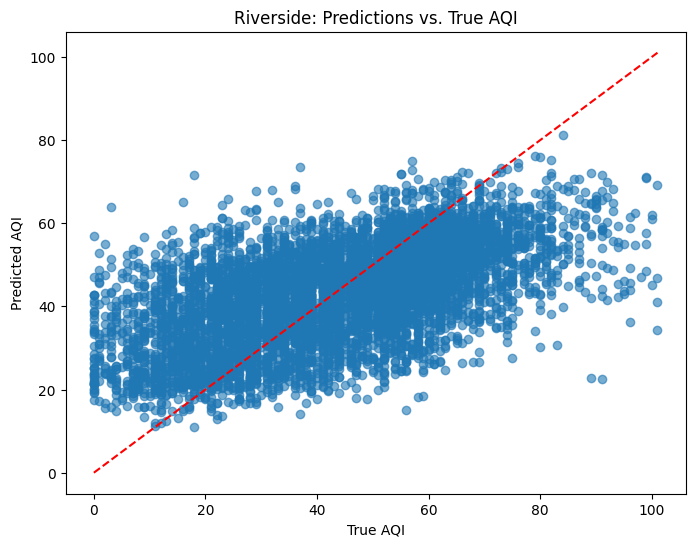

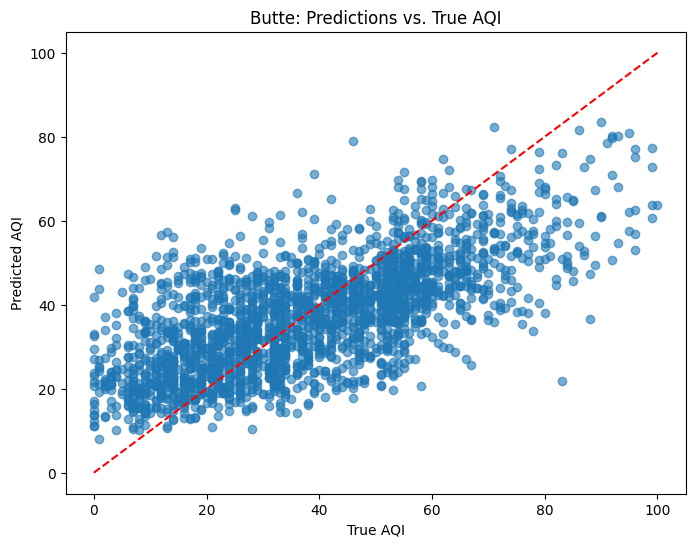

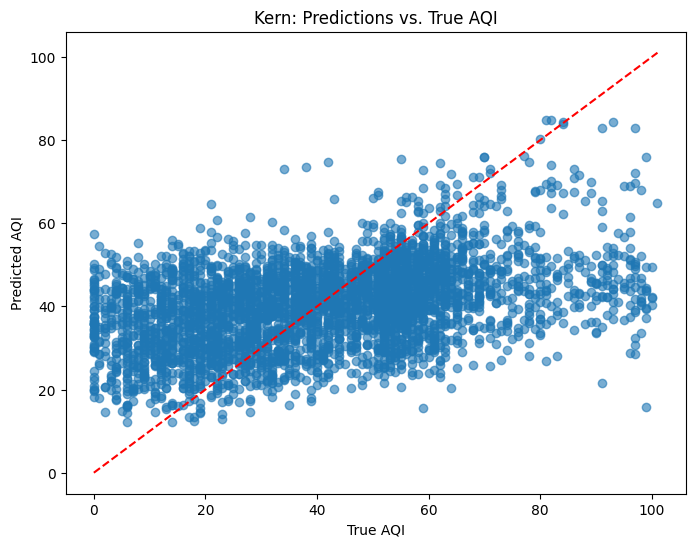

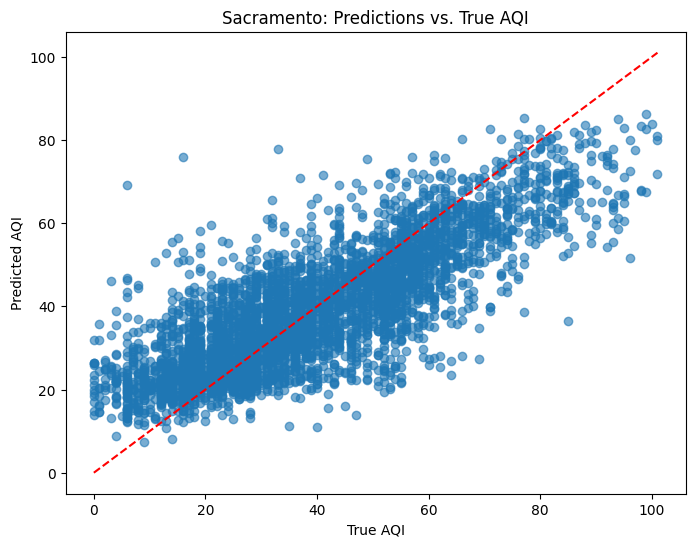

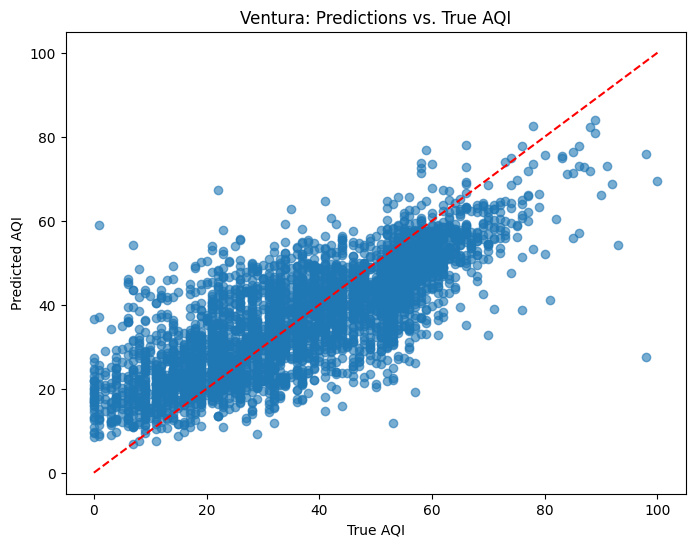

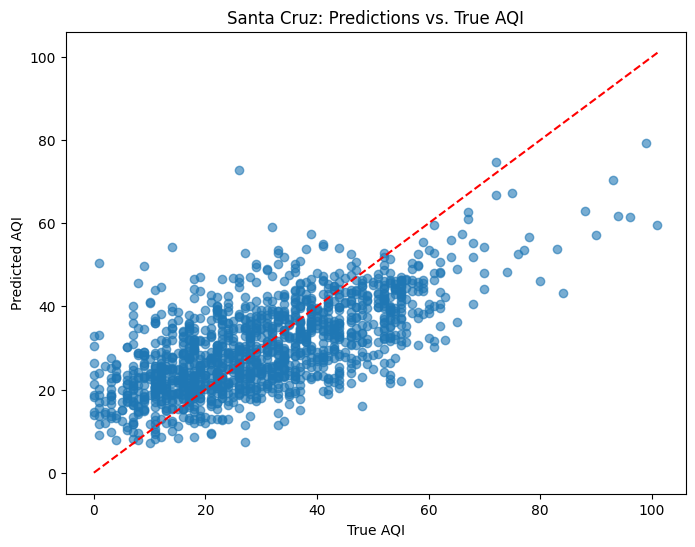

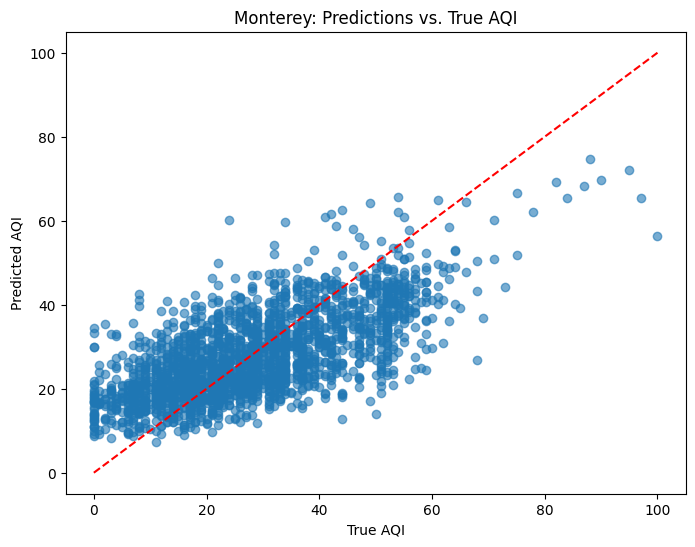

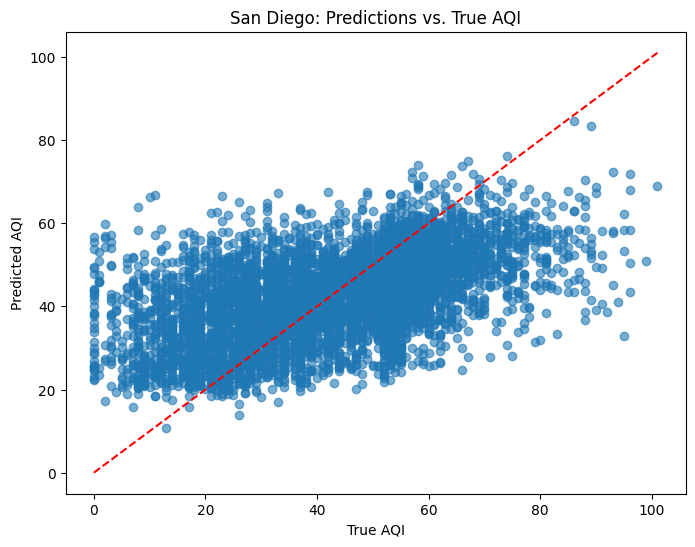

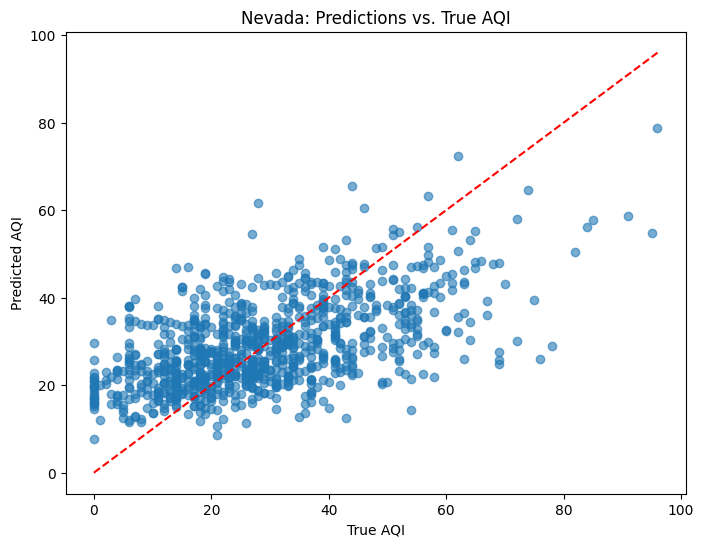

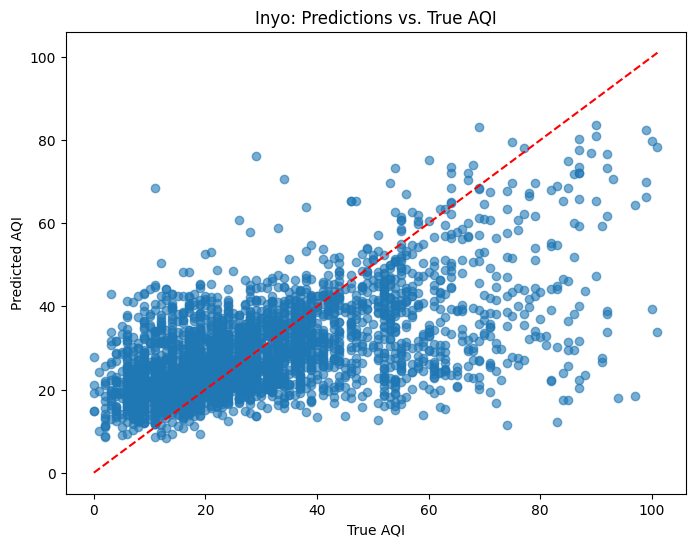

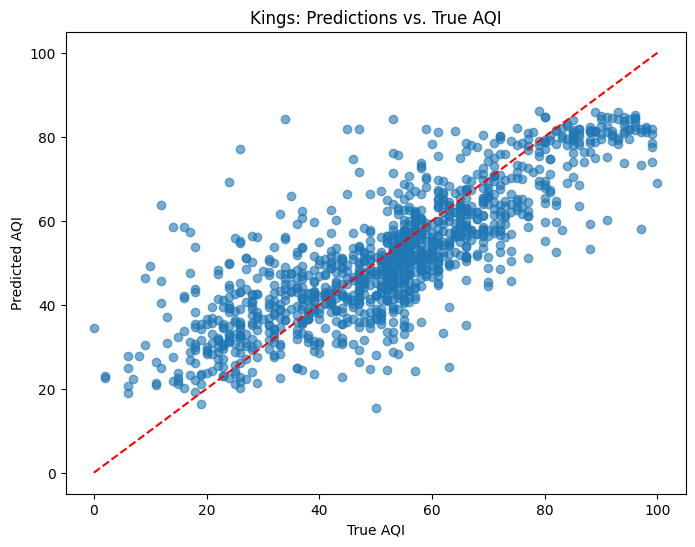

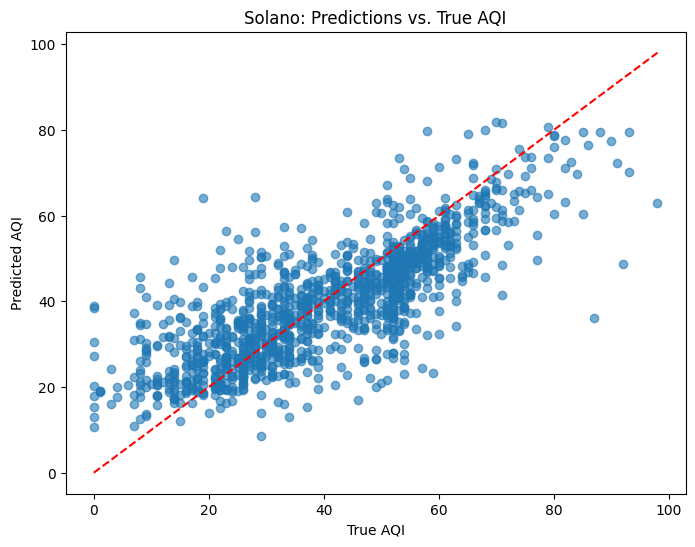

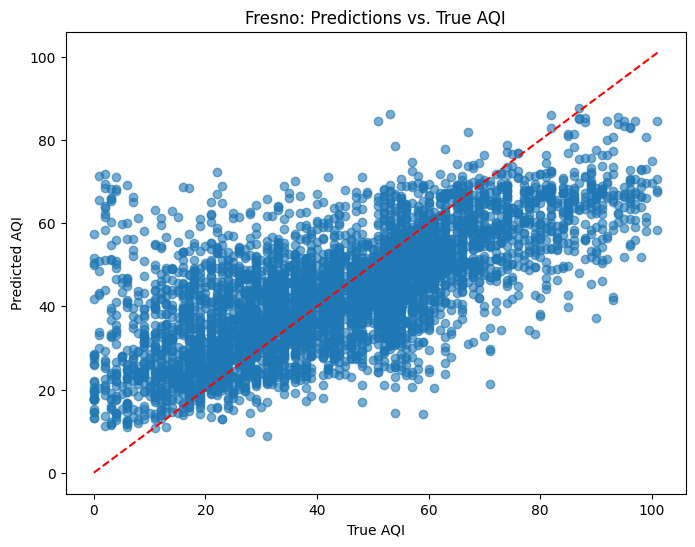

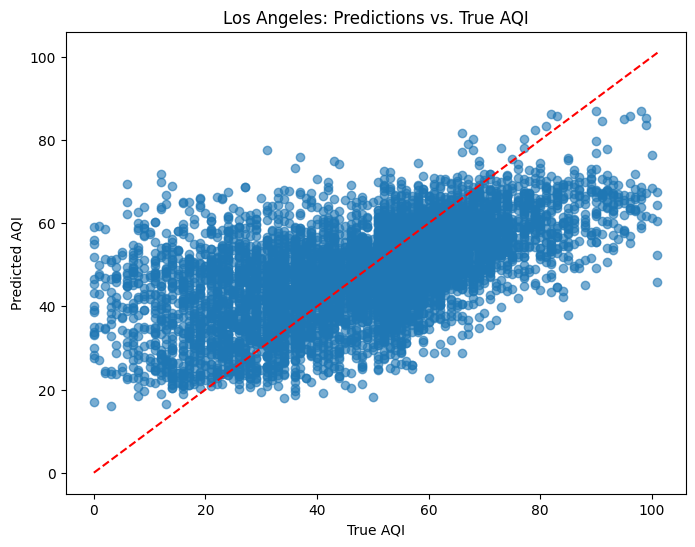

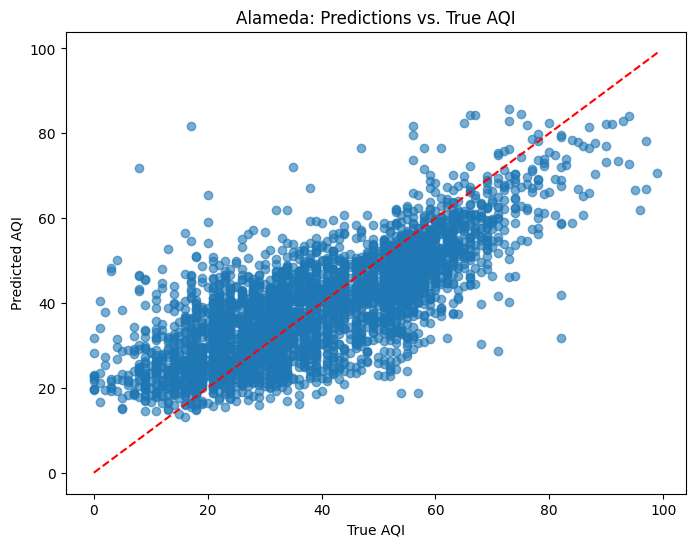

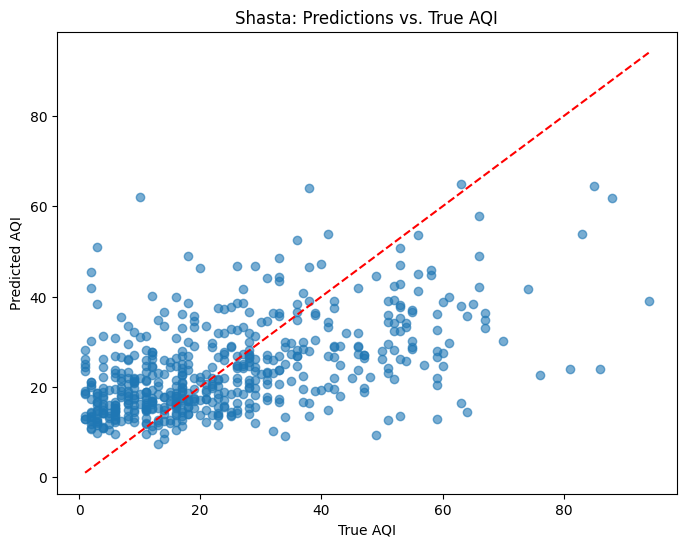

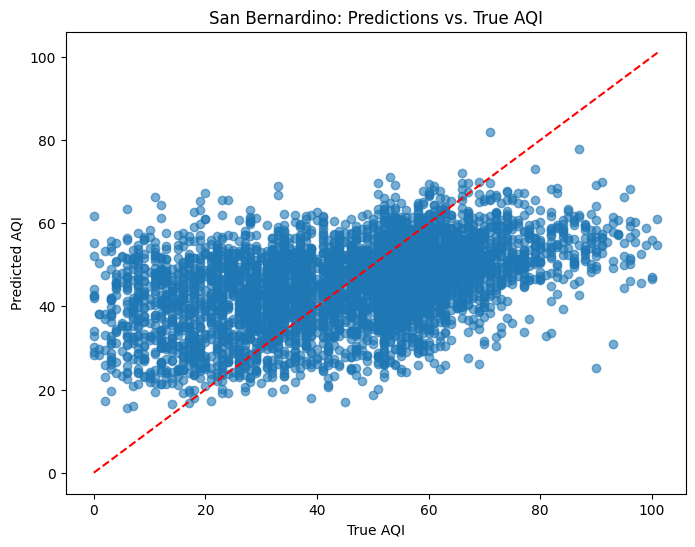

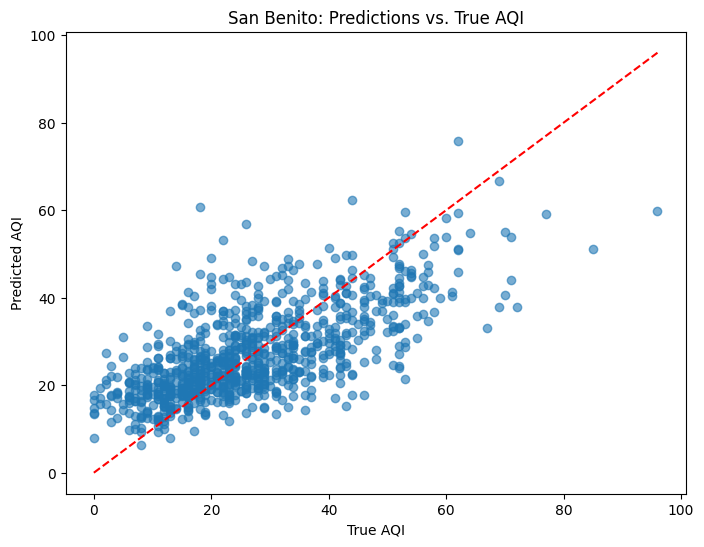

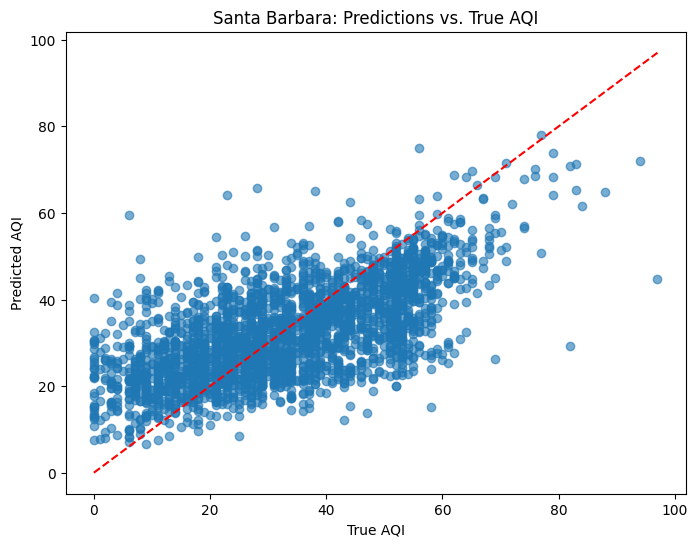

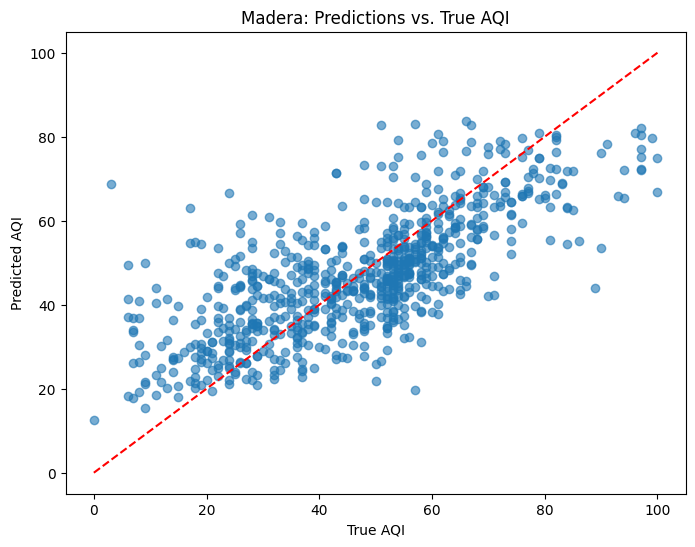

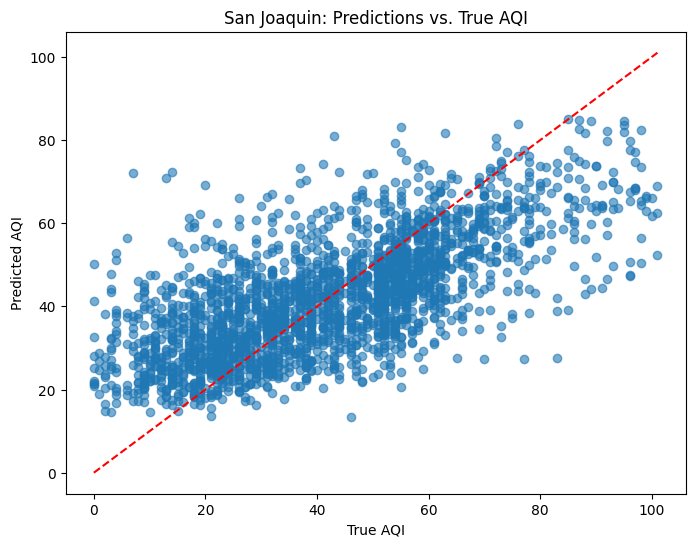

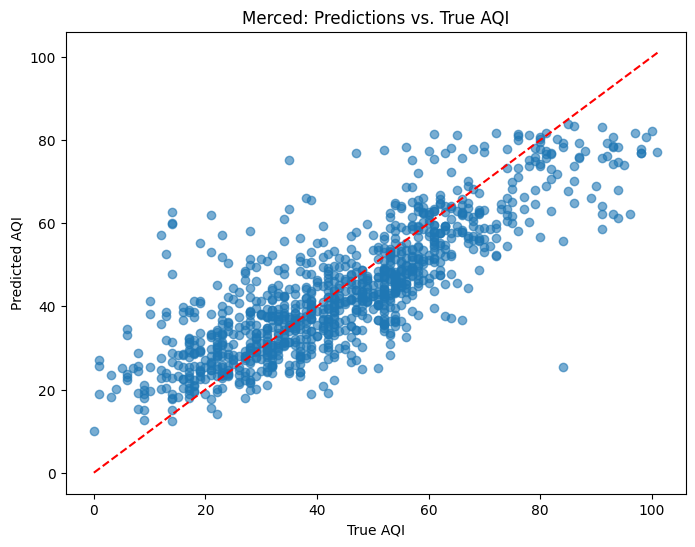

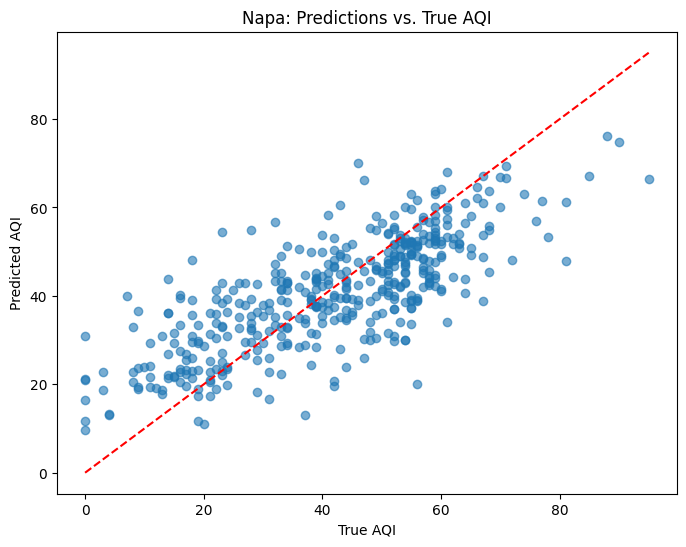

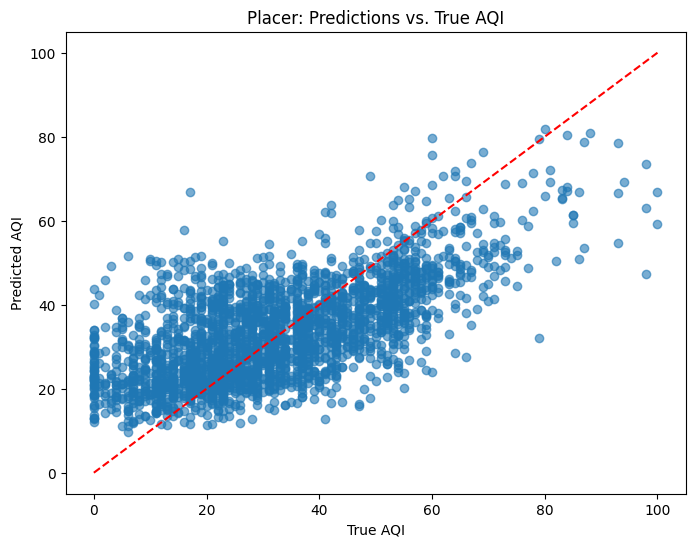

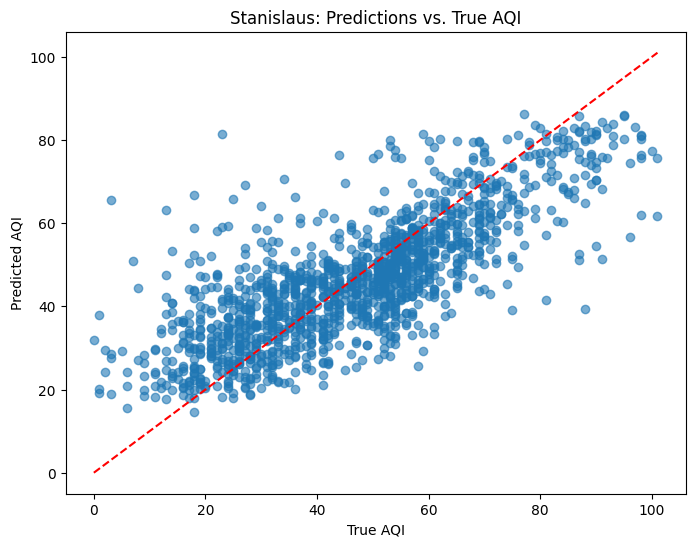

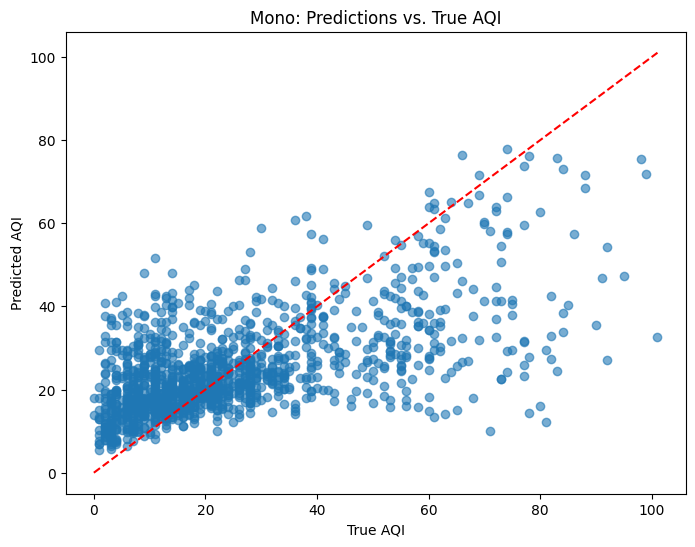

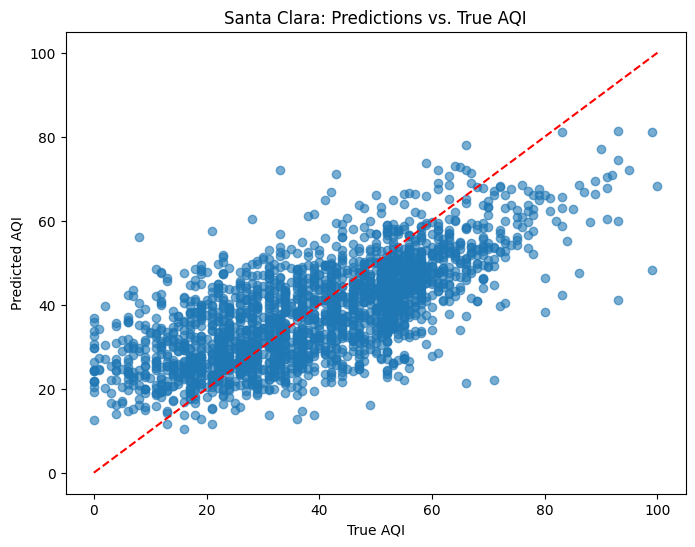

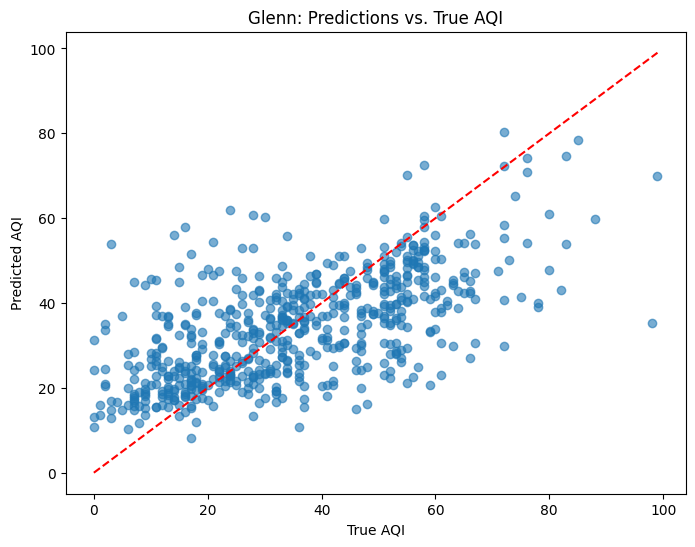

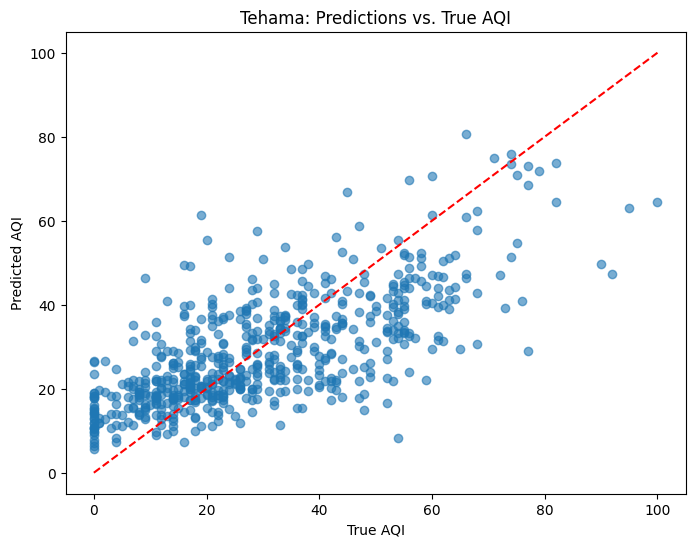

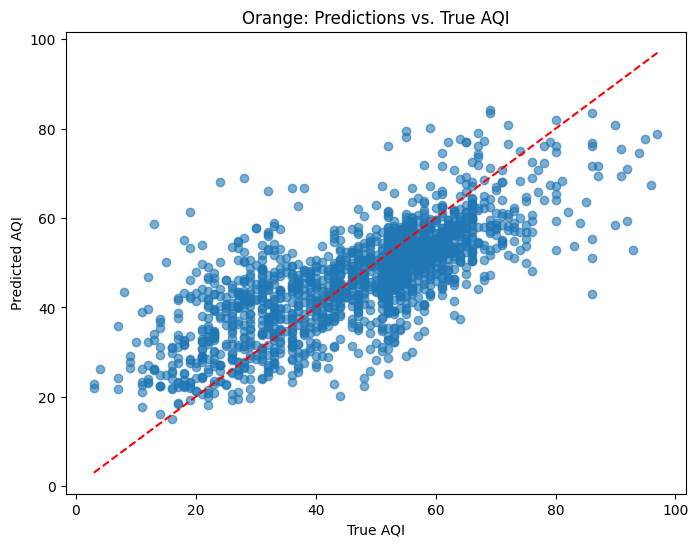

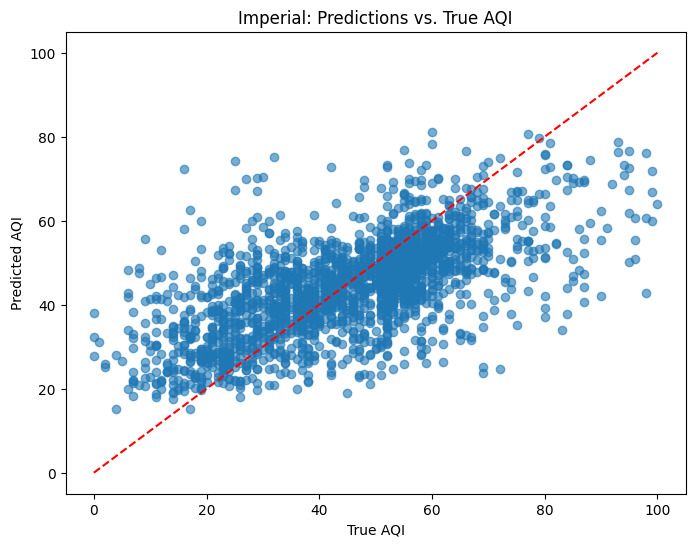

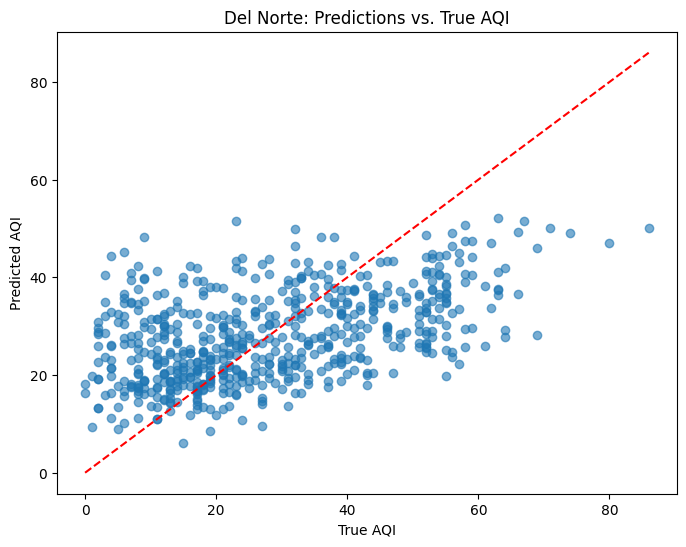

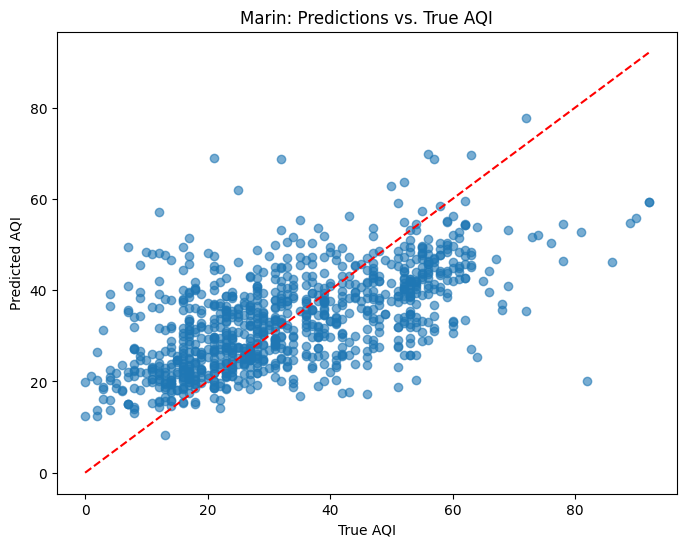

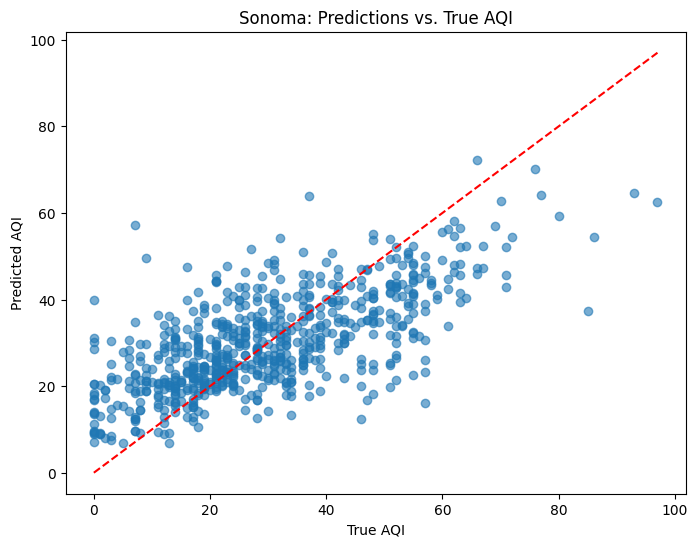

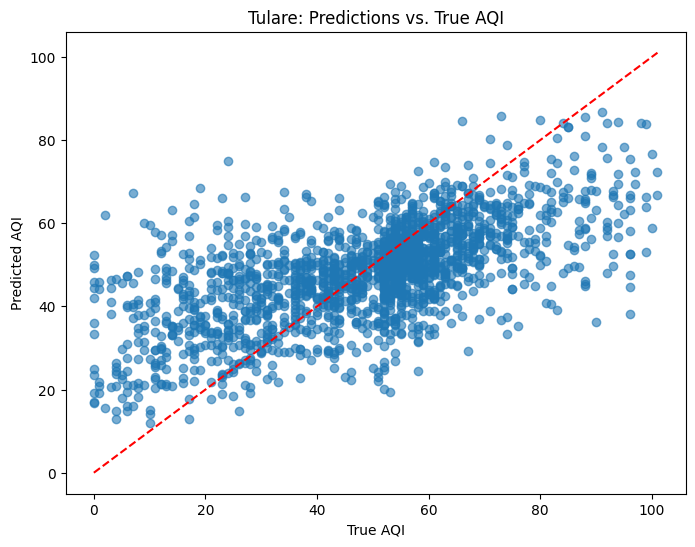

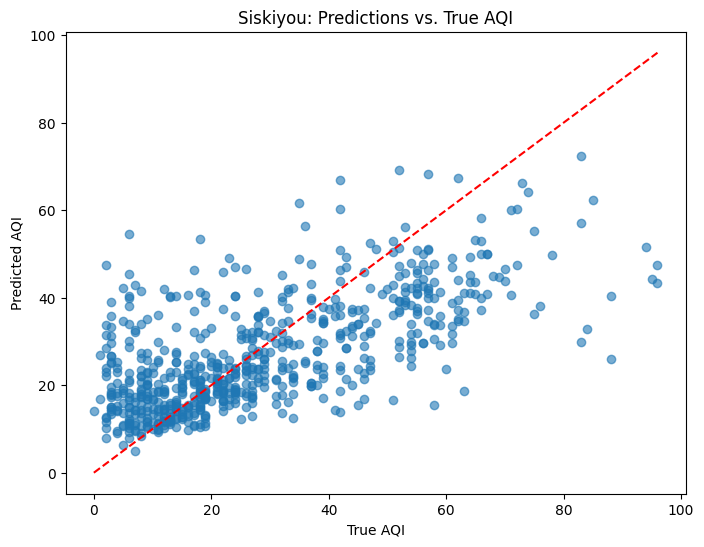

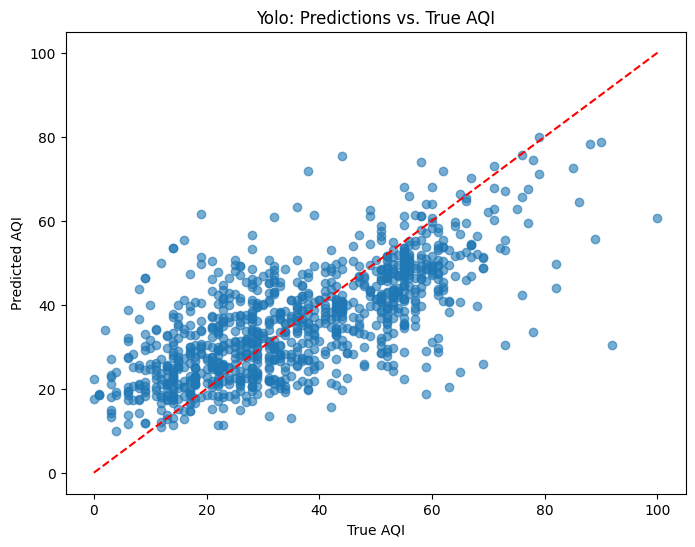

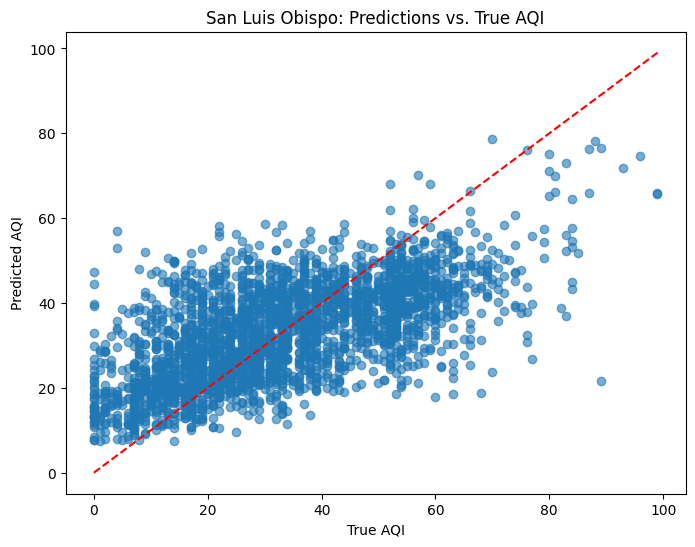

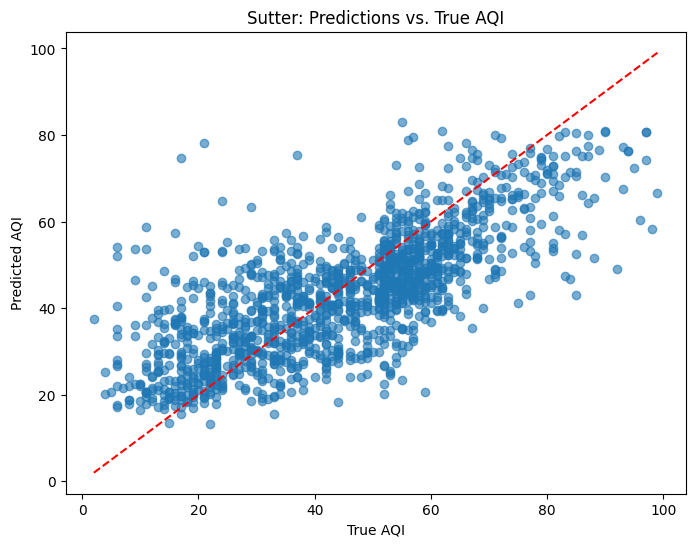

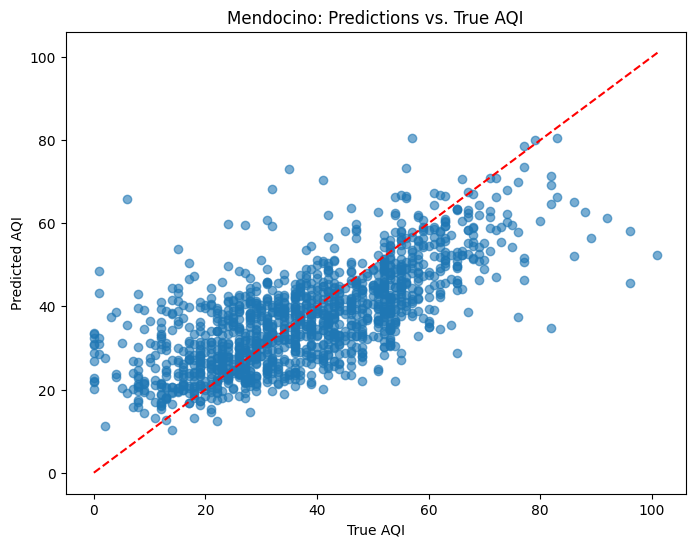

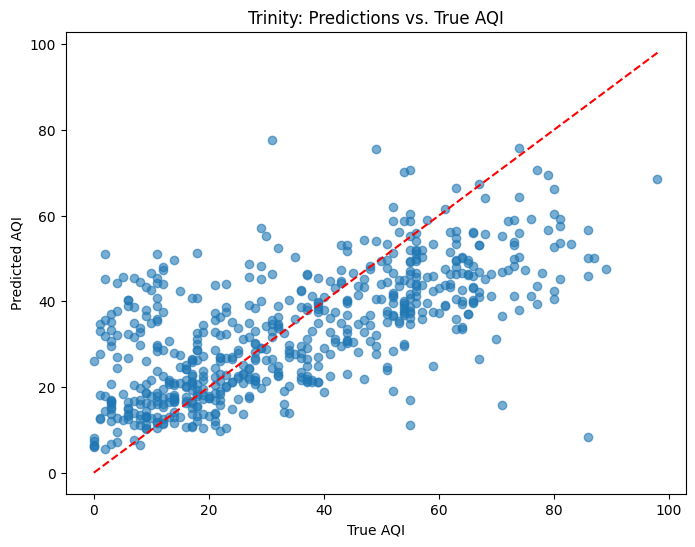

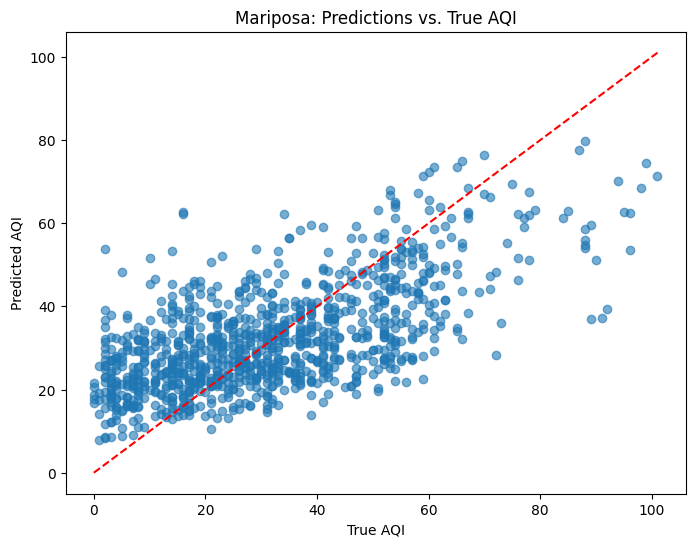

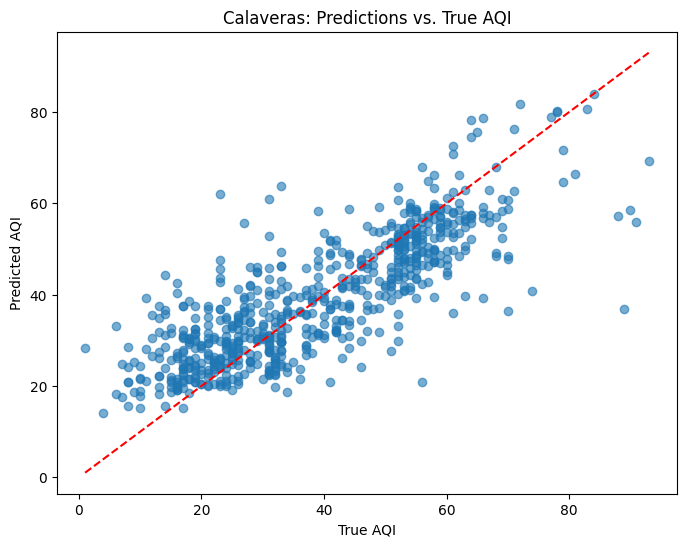

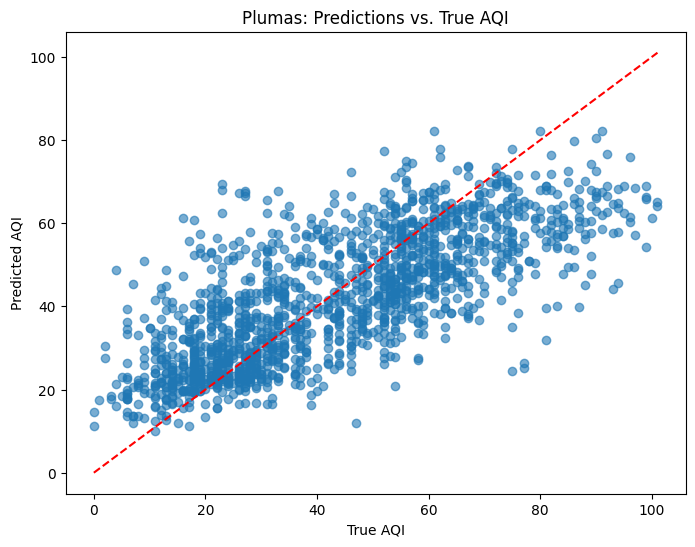

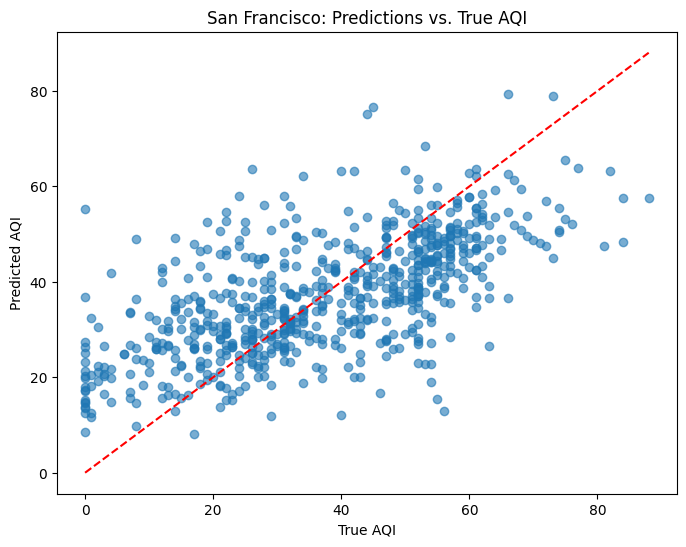

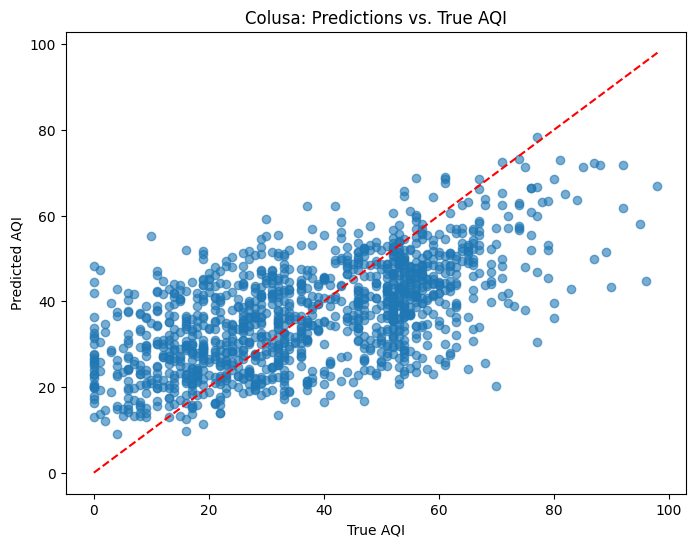

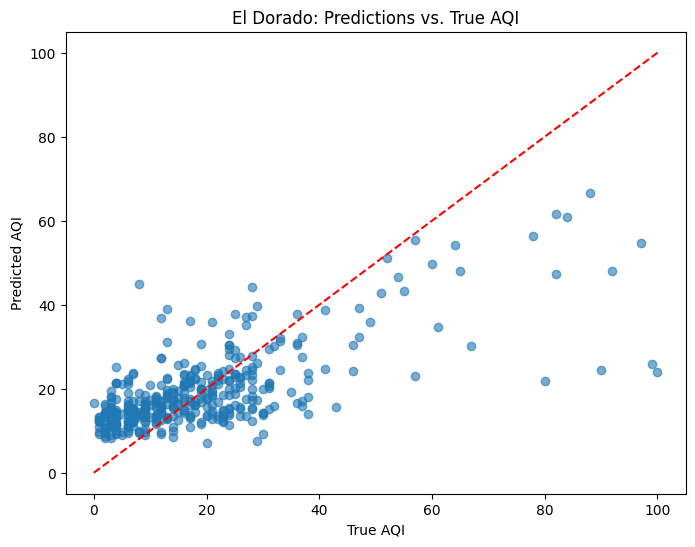

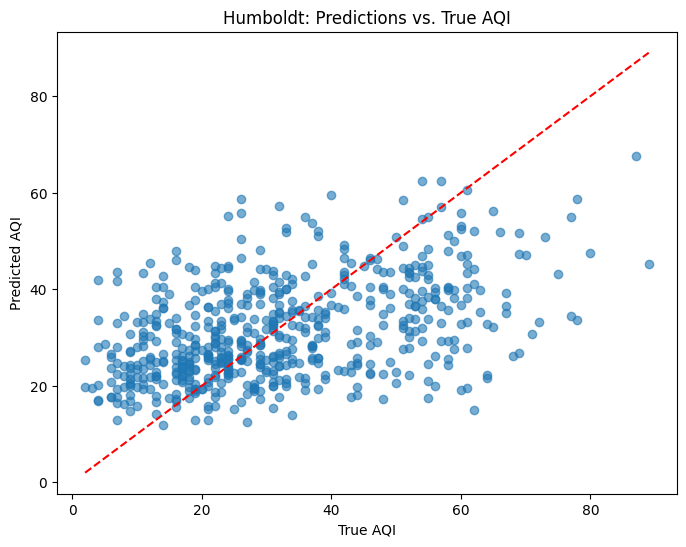

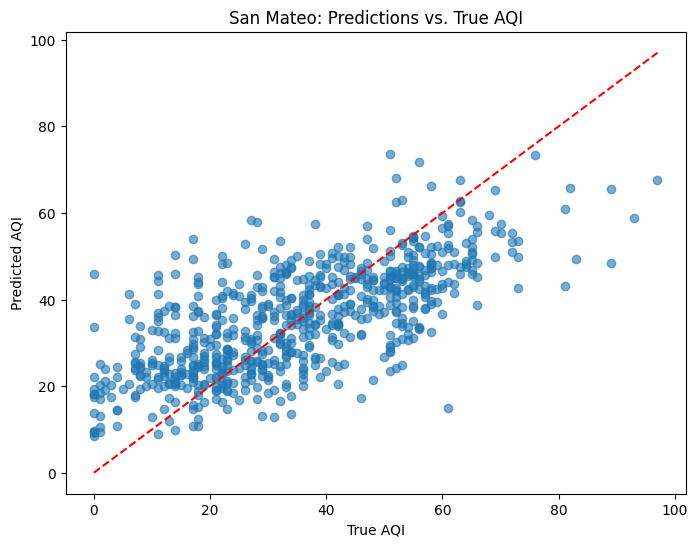

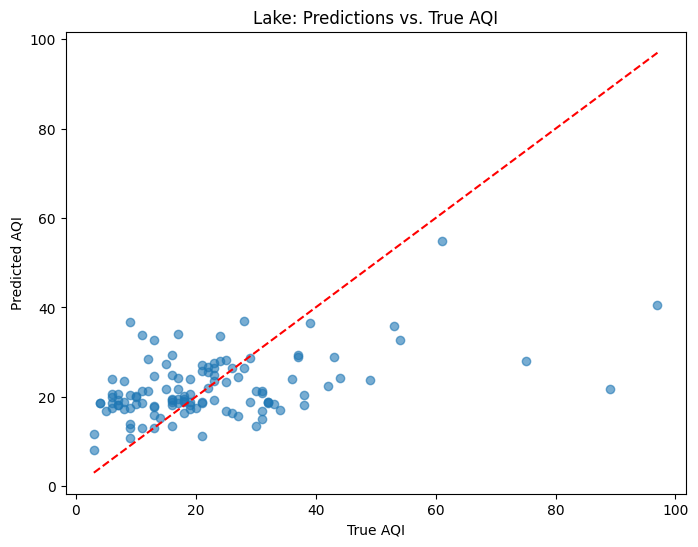

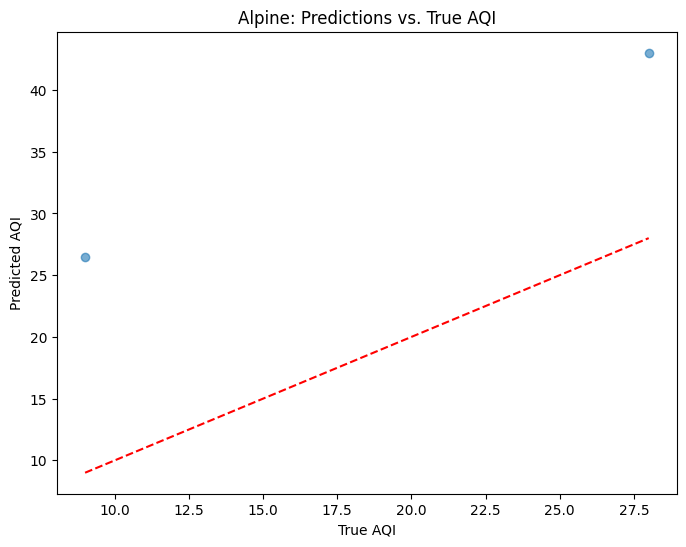

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F

geo_df = pd.read_csv("county_geography.csv")
geo_df["Mean Latitude"] = (geo_df["Mean Latitude"] - geo_df["Mean Latitude"].mean()) / geo_df["Mean Latitude"].std()
geo_df["Mean Longitude"] = (geo_df["Mean Longitude"] - geo_df["Mean Longitude"].mean()) / geo_df["Mean Longitude"].std()

geo_features = geo_df[["Mean Latitude", "Mean Longitude"]].values
k = 4
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(geo_features)
distances, indices = nbrs.kneighbors(geo_features)

neighbor_indices = {}
num_counties = geo_df.shape[0]
for i in range(num_counties):
    neighbor_indices[i] = indices[i][1:].tolist()

device = "cuda" if torch.cuda.is_available() else "cpu"
county_embeddings = torch.load("county_geography_embeddings.pt", map_location=device)
county_embeddings = county_embeddings.to(device)

class CountyAQIDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])
        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}
        self.seq_length = seq_length
        self.samples = []
        for county, group in df.groupby("County"):
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, self.county_to_id[county]))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedLSTM_GNNContext_Attn(nn.Module):
    def __init__(self, seq_length=30, input_size=1, hidden_size=100, lstm_layers=1, gnn_emb_dim=16, context_proj_dim=32):
        super(CountyConditionedLSTM_GNNContext_Attn, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
        self.context_proj = nn.Linear(gnn_emb_dim * 2, context_proj_dim)
        self.fc = nn.Linear(hidden_size + context_proj_dim, 1)

    def forward(self, x, county_idx, county_embeddings, neighbor_indices):
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]
        batch_context = []
        for idx in county_idx.cpu().numpy():
            own_emb = county_embeddings[idx]
            neigh_idx = neighbor_indices[idx]
            neighbor_embs = county_embeddings[neigh_idx]
            attn_scores = torch.matmul(neighbor_embs, own_emb.unsqueeze(-1)).squeeze(-1)
            attn_weights = torch.softmax(attn_scores, dim=0)
            weighted_neigh_emb = (neighbor_embs * attn_weights.unsqueeze(-1)).sum(dim=0)
            combined_emb = torch.cat([own_emb, weighted_neigh_emb], dim=0)
            batch_context.append(combined_emb)
        batch_context = torch.stack(batch_context).to(x.device)
        context = torch.relu(self.context_proj(batch_context))
        combined_features = torch.cat([last_hidden, context], dim=1)
        out = self.fc(combined_features)
        return out.squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30

dataset = CountyAQIDataset(csv_file, seq_length=seq_length)
train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Total samples: {len(dataset)}, Number of counties: {len(dataset.county_to_id)}")

model = CountyConditionedLSTM_GNNContext_Attn(seq_length=seq_length, input_size=1, hidden_size=100,
                                               lstm_layers=2, gnn_emb_dim=16, context_proj_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

print("Training County-Conditioned LSTM with GNN Neighbor Context and Attention...")
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for seq, target, county_idx in train_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        optimizer.zero_grad()
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * seq.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
all_preds = []
all_targets = []
all_county_idxs = []
with torch.no_grad():
    for seq, target, county_idx in test_loader:
        seq = seq.to(device)
        target = target.to(device)
        county_idx = county_idx.to(device)
        pred = model(seq, county_idx, county_embeddings, neighbor_indices)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())
        all_county_idxs.extend(county_idx.cpu().numpy())

rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)
print("Overall Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

torch.save(model.state_dict(), "county_conditioned_lstm_gnncontext.pt")
print("Model parameters saved to county_conditioned_lstm_gnncontext.pt")

from collections import defaultdict

county_results = defaultdict(lambda: {"preds": [], "targets": []})
for pred, true, c_idx in zip(all_preds, all_targets, all_county_idxs):
    county_name = dataset.id_to_county[c_idx]
    county_results[county_name]["preds"].append(pred)
    county_results[county_name]["targets"].append(true)

per_county_metrics = {}
for county, values in county_results.items():
    y_true = np.array(values["targets"])
    y_pred = np.array(values["preds"])
    rmse_c = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_c = mean_absolute_error(y_true, y_pred)
    per_county_metrics[county] = {"RMSE": rmse_c, "MAE": mae_c, "n_samples": len(y_true)}

metrics_df = pd.DataFrame.from_dict(per_county_metrics, orient='index').reset_index().rename(columns={"index": "County"})
print("Per-County Evaluation Metrics:")
print(metrics_df)

plt.figure(figsize=(12, 6))
metrics_df = metrics_df.sort_values("RMSE")
plt.bar(metrics_df["County"], metrics_df["RMSE"], color="skyblue")
plt.xlabel("County")
plt.ylabel("RMSE")
plt.title("Per-County RMSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
metrics_df = metrics_df.sort_values("MAE")
plt.bar(metrics_df["County"], metrics_df["MAE"], color="lightgreen")
plt.xlabel("County")
plt.ylabel("MAE")
plt.title("Per-County MAE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

for county, values in county_results.items():
    y_true = np.array(values["targets"])
    y_pred = np.array(values["preds"])
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("True AQI")
    plt.ylabel("Predicted AQI")
    plt.title(f"{county}: Predictions vs. True AQI")
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

def load_and_prepare_data(csv_file="combined_aqi_data.csv"):
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df = df.sort_values('Date')
    df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
    df = df.dropna(subset=["Daily AQI Value"])
    return df

class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = load_and_prepare_data(csv_file)
        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}
        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])

class CountyConditionedCNNLSTM(nn.Module):
    def __init__(self, seq_length=30, input_size=1, cnn_channels=32, lstm_hidden_size=64, lstm_layers=2,
                 county_vocab_size=10, county_emb_dim=16):
        super(CountyConditionedCNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.fc = nn.Linear(lstm_hidden_size + county_emb_dim, 1)

    def forward(self, x, county_id):
        x = x.transpose(1, 2)
        cnn_out = self.relu(self.conv1(x))
        cnn_out = cnn_out.transpose(1, 2)
        lstm_out, _ = self.lstm(cnn_out)
        last_hidden = lstm_out[:, -1, :]
        county_emb = self.county_embedding(county_id)
        combined = torch.cat([last_hidden, county_emb], dim=1)
        out = self.fc(combined)
        return out.squeeze(1)

def train_model(model, dataloader, criterion, optimizer, num_epochs=20, device="cuda"):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30
dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
county_vocab_size = len(dataset.county_to_id)
print(f"Total samples: {len(dataset)}, Number of counties: {county_vocab_size}")

train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = CountyConditionedCNNLSTM(seq_length=seq_length, input_size=1, cnn_channels=32, lstm_hidden_size=64,
                                 lstm_layers=2, county_vocab_size=county_vocab_size, county_emb_dim=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
print("Training County-Conditioned CNN-LSTM Model...")
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
print("County-Conditioned CNN-LSTM Model Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Total samples: 534682, Number of counties: 52
Training County-Conditioned CNN-LSTM Model...
Epoch 1/20, Loss: 242.7890
Epoch 2/20, Loss: 206.6191
Epoch 3/20, Loss: 204.4938
Epoch 4/20, Loss: 203.5932
Epoch 5/20, Loss: 202.8092
Epoch 6/20, Loss: 202.3402
Epoch 7/20, Loss: 202.1649
Epoch 8/20, Loss: 201.6143
Epoch 9/20, Loss: 201.3503
Epoch 10/20, Loss: 200.9008
Epoch 11/20, Loss: 200.7907
Epoch 12/20, Loss: 200.4435
Epoch 13/20, Loss: 200.3560
Epoch 14/20, Loss: 200.1881
Epoch 15/20, Loss: 199.9946
Epoch 16/20, Loss: 199.8736
Epoch 17/20, Loss: 199.8777
Epoch 18/20, Loss: 199.8041
Epoch 19/20, Loss: 199.5807
Epoch 20/20, Loss: 199.1477
County-Conditioned CNN-LSTM Model Evaluation:
RMSE: 14.27, MAE: 11.05


In [ ]:
torch.save(model.state_dict(), "county_conditioned_cnn_lstm.pt")

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error


class CountyTimeSeriesDataset(Dataset):
    def __init__(self, csv_file, seq_length=30):
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])
        df = df.sort_values('Date')
        df['Daily AQI Value'] = pd.to_numeric(df['Daily AQI Value'], errors='coerce')
        df = df.dropna(subset=["Daily AQI Value"])

        counties = sorted(df["County"].unique())
        self.county_to_id = {county: i for i, county in enumerate(counties)}
        self.id_to_county = {i: county for county, i in self.county_to_id.items()}

        self.seq_length = seq_length
        self.samples = []
        grouped = df.groupby("County")
        for county, group in grouped:
            group = group.sort_values("Date")
            ts = group["Daily AQI Value"].values.astype(np.float32)
            county_id = self.county_to_id[county]
            if len(ts) < seq_length + 1:
                continue
            for i in range(len(ts) - seq_length):
                seq = ts[i:i+seq_length]
                target = ts[i+seq_length]
                self.samples.append((seq, target, county_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target, county_id = self.samples[idx]
        return (torch.tensor(seq).unsqueeze(1),
                torch.tensor(target, dtype=torch.float32),
                torch.tensor(county_id, dtype=torch.long))

def train_test_split_dataset(dataset, train_ratio=0.8):
    total = len(dataset)
    split_idx = int(total * train_ratio)
    indices = np.arange(total)
    np.random.shuffle(indices)
    from torch.utils.data import Subset
    return Subset(dataset, indices[:split_idx]), Subset(dataset, indices[split_idx:])


class CountyConditionedHybridAttentionModel(nn.Module):
    def __init__(self, seq_length=30, input_size=1, cnn_channels=32, cnn_kernel_size=3,
                 lstm_hidden_size=64, lstm_layers=2, county_vocab_size=10, county_emb_dim=16, dropout=0.3):
        super(CountyConditionedHybridAttentionModel, self).__init__()
        self.seq_length = seq_length

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=cnn_channels,
                      kernel_size=cnn_kernel_size, padding=cnn_kernel_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_channels),
            nn.Dropout(dropout)
        )
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers, dropout=dropout, batch_first=True)
        self.attention_layer = nn.Linear(lstm_hidden_size, 1)
        self.layer_norm = nn.LayerNorm(lstm_hidden_size)
        self.county_embedding = nn.Embedding(county_vocab_size, county_emb_dim)
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_size + county_emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x, county_id):
        x_cnn = x.transpose(1, 2)
        cnn_out = self.cnn(x_cnn)
        cnn_out = cnn_out.transpose(1, 2)

        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = self.layer_norm(lstm_out)

        attn_weights = torch.softmax(self.attention_layer(lstm_out).squeeze(-1), dim=1)
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        county_emb = self.county_embedding(county_id)

        combined = torch.cat([context, county_emb], dim=1)
        output = self.fc(combined)
        return output.squeeze(1)


def train_model(model, dataloader, criterion, optimizer, num_epochs=30, device="cuda", clip_grad=1.0):
    model.train()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            optimizer.zero_grad()
            pred = model(seq, county_id)
            loss = criterion(pred, target)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            epoch_loss += loss.item() * seq.size(0)
        epoch_loss /= len(dataloader.dataset)
        scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for seq, target, county_id in dataloader:
            seq = seq.to(device)
            target = target.to(device)
            county_id = county_id.to(device)
            pred = model(seq, county_id)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return predictions, targets, rmse, mae

device = "cuda" if torch.cuda.is_available() else "cpu"
csv_file = "combined_aqi_data_iqr.csv"
seq_length = 30

dataset = CountyTimeSeriesDataset(csv_file, seq_length=seq_length)
county_vocab_size = len(dataset.county_to_id)
print(f"Total samples: {len(dataset)}, Number of counties: {county_vocab_size}")

train_dataset, test_dataset = train_test_split_dataset(dataset, train_ratio=0.8)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = CountyConditionedHybridAttentionModel(seq_length=seq_length, input_size=1,
                                                cnn_channels=32, cnn_kernel_size=3,
                                                lstm_hidden_size=64, lstm_layers=2,
                                                county_vocab_size=county_vocab_size, county_emb_dim=16,
                                                dropout=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Training advanced county-conditioned hybrid model...")
num_epochs = 30
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

preds, trues, rmse, mae = evaluate_model(model, test_loader, device=device)
print("Advanced County-Conditioned Hybrid Model Evaluation:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Total samples: 534682, Number of counties: 52
Training advanced county-conditioned hybrid model...
Epoch 1/30, Loss: 256.8203
Epoch 2/30, Loss: 236.3240
Epoch 3/30, Loss: 230.3863
Epoch 4/30, Loss: 225.6886
Epoch 5/30, Loss: 221.7012
Epoch 6/30, Loss: 218.6648
Epoch 7/30, Loss: 216.4236
Epoch 8/30, Loss: 215.1046
Epoch 9/30, Loss: 213.5220
Epoch 10/30, Loss: 212.9902
Epoch 11/30, Loss: 210.7617
Epoch 12/30, Loss: 210.0723
Epoch 13/30, Loss: 209.4319
Epoch 14/30, Loss: 208.6849
Epoch 15/30, Loss: 208.1749
Epoch 16/30, Loss: 208.0021
Epoch 17/30, Loss: 207.5714
Epoch 18/30, Loss: 207.3126
Epoch 19/30, Loss: 206.9982
Epoch 20/30, Loss: 206.6722
Epoch 21/30, Loss: 205.6386
Epoch 22/30, Loss: 205.2852
Epoch 23/30, Loss: 204.9007
Epoch 24/30, Loss: 205.1881
Epoch 25/30, Loss: 204.7228
Epoch 26/30, Loss: 204.6621
Epoch 27/30, Loss: 204.4605
Epoch 28/30, Loss: 204.3606
Epoch 29/30, Loss: 204.3100
Epoch 30/30, Loss: 204.3490
Advanced County-Conditioned Hybrid Model Evaluation:
RMSE: 14.08, MAE:

In [ ]:
torch.save(model.state_dict(), "advanced_county_conditioned_hybrid_model.pt")
print("Model parameters saved to advanced_county_conditioned_hybrid_model.pt")

Model parameters saved to advanced_county_conditioned_hybrid_model.pt


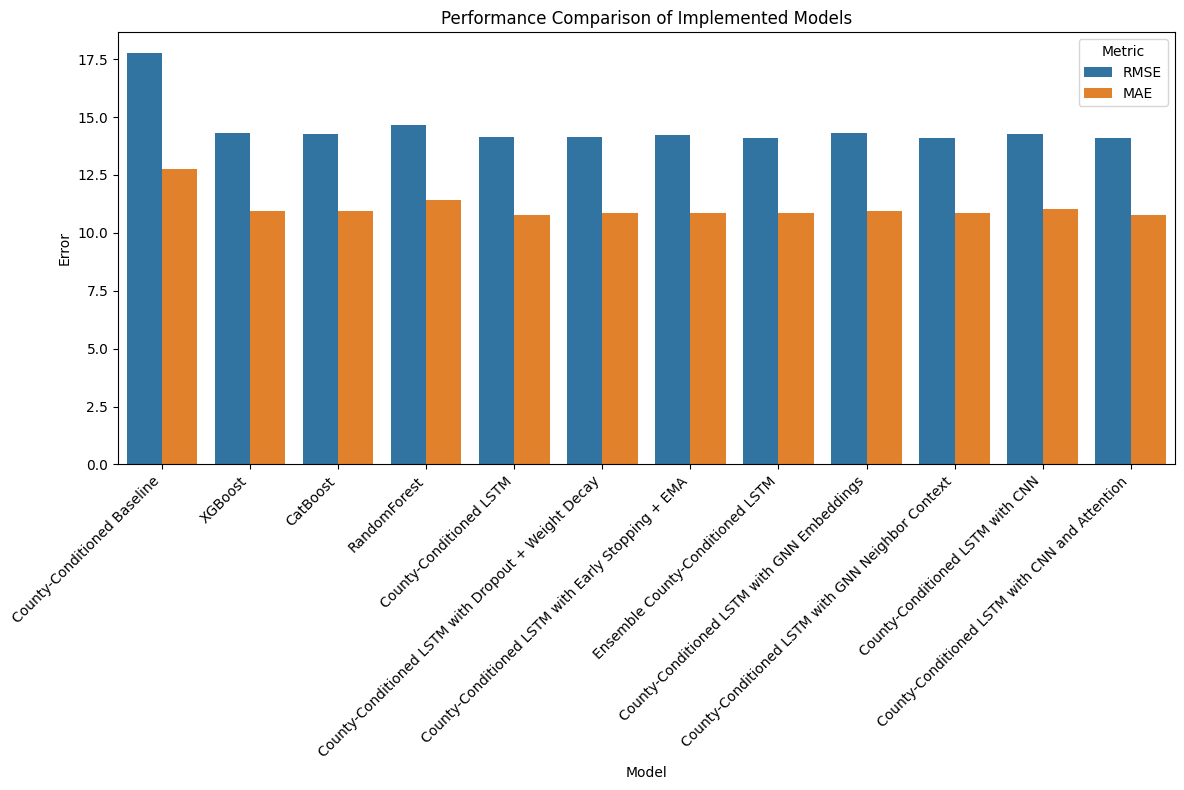

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "Model": [
        "County-Conditioned Baseline",
        "XGBoost",
        "CatBoost",
        "RandomForest",
        "County-Conditioned LSTM",
        "County-Conditioned LSTM with Dropout + Weight Decay",
        "County-Conditioned LSTM with Early Stopping + EMA",
        "Ensemble County-Conditioned LSTM",
        "County-Conditioned LSTM with GNN Embeddings",
        "County-Conditioned LSTM with GNN Neighbor Context",
        "County-Conditioned LSTM with CNN",
        "County-Conditioned LSTM with CNN and Attention"
    ],
    "RMSE": [17.77, 14.31, 14.28, 14.64, 14.16, 14.14, 14.21, 14.11, 14.33, 14.10, 14.27, 14.08],
    "MAE": [12.75, 10.94, 10.93, 11.40, 10.79, 10.85, 10.85, 10.84, 10.94, 10.84, 11.05, 10.76]
}

df = pd.DataFrame(data)

df_melted = df.melt(id_vars="Model", value_vars=["RMSE", "MAE"],
                    var_name="Metric", value_name="Value")

plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x="Model", y="Value", hue="Metric")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model")
plt.ylabel("Error")
plt.title("Performance Comparison of Implemented Models")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

<ipython-input-11-2b2286900d76>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x="Model", y="RMSE", data=df_rmse, palette="Blues_d")
<ipython-input-11-2b2286900d76>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-11-2b2286900d76>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x="Model", y="MAE", data=df_mae, palette="Greens_d")
<ipython-input-11-2b2286900d76>:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocato

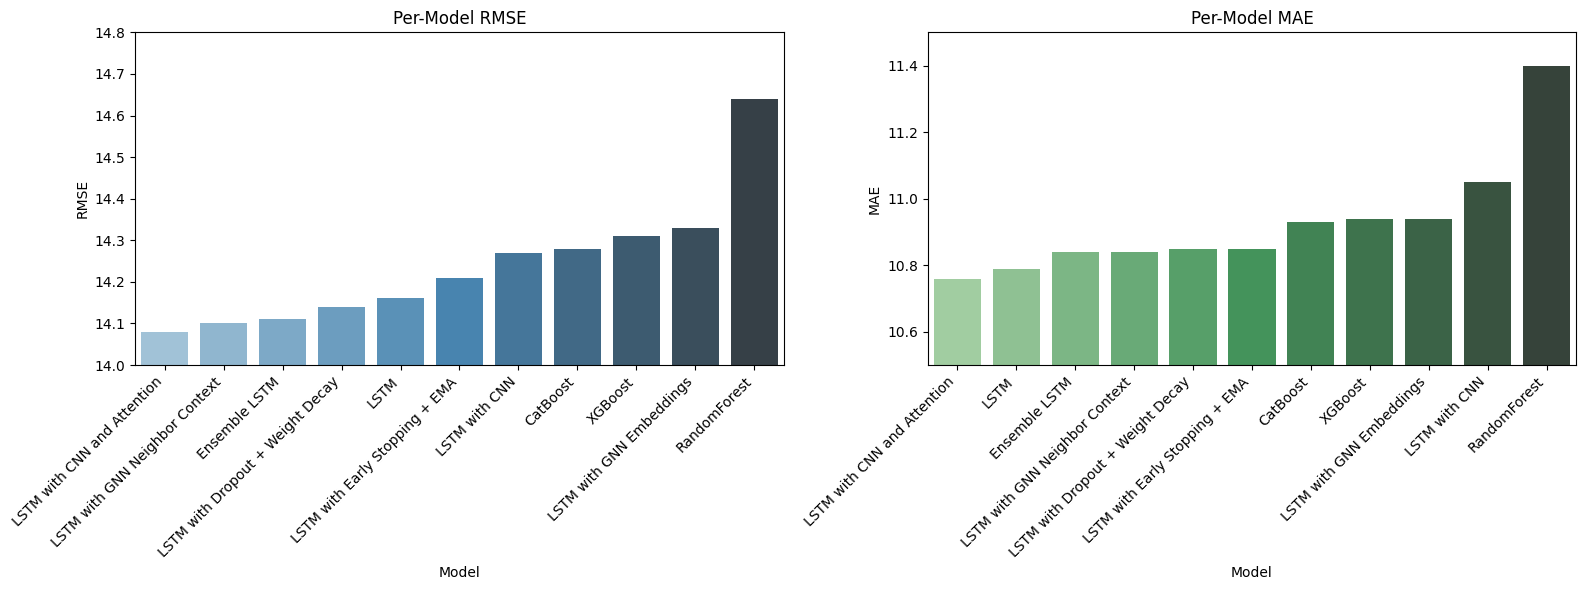

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    "Model": [
        "XGBoost",
        "CatBoost",
        "RandomForest",
        "LSTM",
        "LSTM with Dropout + Weight Decay",
        "LSTM with Early Stopping + EMA",
        "Ensemble LSTM",
        "LSTM with GNN Embeddings",
        "LSTM with GNN Neighbor Context",
        "LSTM with CNN",
        "LSTM with CNN and Attention"
    ],
    "RMSE": [14.31, 14.28, 14.64, 14.16, 14.14, 14.21, 14.11, 14.33, 14.10, 14.27, 14.08],
    "MAE": [10.94, 10.93, 11.40, 10.79, 10.85, 10.85, 10.84, 10.94, 10.84, 11.05, 10.76]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_rmse = df.sort_values("RMSE")
sns.barplot(ax=axes[0], x="Model", y="RMSE", data=df_rmse, palette="Blues_d")
axes[0].set_title("Per-Model RMSE")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("RMSE")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_ylim(14, 14.8)

df_mae = df.sort_values("MAE")
sns.barplot(ax=axes[1], x="Model", y="MAE", data=df_mae, palette="Greens_d")
axes[1].set_title("Per-Model MAE")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_ylim(10.5, 11.5)

plt.tight_layout()
plt.show()